In [1]:
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    LeaveOneGroupOut,
    LeaveOneOut,
    LeavePGroupsOut,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    StandardScaler,
)
from sklearn.svm import SVR

# Task

## Aim
We were tasked to evaluate the endangerment of species as well as their developement and the characteristics of the countries they inhabit. 

## Questions
- How many species are endangered in total?
- How many species are endangered by group/country?
- What characteristics influence the overall trend of endangerment in a country?
- Can the trend of endangerement be predicted inside a country?
- Can the number of endangered species be predicted inside a country?


# Approach
To reach our goal we gathered and processed Data from 3 Sources. Firstly we used the IUCN Redlist to identify species per country as well as their endangerment status. We were unable to gather historic data, as only the recent data was freely available. Secondly as support datasets we gathered country characteristics from OECD from their open database. After considering the available dataset we decided for their greenhouse gases, land cover and land usage datasets were the most useful for this task. Thirdly we decided to supplement our data with climate information, because we suspect climate change to have a large role in the endangerment of species. For this purpose we used the data available from worldbank.

The data from the IUCN Redlist had to be web scraped, as no usable format was openly available, here we decided on only handling land based animals to increase the connection to the countries. For the other data sources a csv download was available. 
Afterwards the downloaded data was normalized, grouping the species into their respective classes (e.g. mammal) and standardizing the endangerment threat levels. Missing data was handled and a relative value according to the groups were defined to help in further steps.

The support datasets were handled in the schema 

1. Loading Data
2. Cleaning Data
3. Feature Preperation (including the interpolation of current data were neccesary)
4. Data Exploration


In the next steps the datasets were combined and an analysis on the combined dataset was done.

Finally we generated models that were capable to predict the trend of species endangerement by their respective groups inside countries, as well as predict the number of endangered species by country relative to the total number of species in that country.


# Data

We use three data sources for our analysis:

Our main data source is the International Union For Conservation of Nature (IUCN). 
This is an international organization working on the field of nature conservation. 
They provide the most relevant and detaild data on threatened and extinct species.

We selected the OECD repository as our second source of data because it provides different good quality data sets on enviornment and biodiversity.
Data is provided on a per country level.
As not all countries are members of the OECD or have a close relationship with it this limits the number of countries we can use for our analysis.

As the third data source we selected climate dataset provided by [the World Bank Group](https://climateknowledgeportal.worldbank.org/download-data). The datasets constists of temperature and rainfall data for the years 1990 to 2016 on a country level. 

In [2]:
# set data path
DATA_PATH = Path('./data/')

## Selected countries

We select all countries we have information on across all used data sets.
Countries selected are listed in a seperate yaml file "countries.yml" and structured by region which is needed for scraping the data from the IUCN webpage.
This further provides a single method to filter our data and make sure all data sets have information on the same countries.
We initally chose 65 countries that are present in all datasets available from the OECD repository and on the IUCN webpage.

In [3]:
COUNTRIES_YAML = Path('./countries.yml')

# get names of selected countries from YAML file
def get_country_list():
    countries = []
    with open(COUNTRIES_YAML, 'r') as cfg_file:
        cfg = yaml.safe_load(cfg_file)
    for region in cfg['countries']:
        countries += cfg['countries'][region]
    return countries

# get names of selected countries from YAML file
# names of countries slightly differ for the IUCN webpage
def get_countries_for_IUCN():
    region_country_list = []
    with open(COUNTRIES_YAML, 'r') as cfg_file:
        cfg = yaml.safe_load(cfg_file)
    for region_name in cfg['countries']:
        for country_name in cfg['countries'][region_name]:
            country_dict = {}
            country_dict['region_name'] = region_name
            country_dict['country_name'] = country_name
            if country_name in list(cfg['IUCN_name_transform'].keys()):
                country_dict['country_iucn'] = cfg['IUCN_name_transform'][country_name]
            else:
                country_dict['country_iucn'] = country_name
            region_country_list.append(country_dict)

    return region_country_list

SELECTED_COUNTRIES = get_country_list()
COUNTY_IUCN_DICT = get_countries_for_IUCN()
print(f'Inital number selected countries: {len(SELECTED_COUNTRIES)}')

Inital number selected countries: 65


## IUCN Redlist Data

#### Difficulties
We encountered several difficulties for utilizing the data provided by the IUCN.

First, summery statistics. The provided data is mostly in a format that is not machine readable (PDFs) or when machine readable files (CSVs) are provided the data is not in sufficient detail per country.

Second, spatial data. This type of data provides detailed information per group of species.
The data is provided as polygons but as our goal is to compare different characteristics of countries we would have to map the polygons to countries which is not a trivial task as the IUCNs process to define which species is resident in which country is very sophisticated and not easy to reproduce.

Third, there is no "historical" data on threatened species.
Only some PDFs document the changes in status per species and year but the IUCN specifically states that "This table (Table 7) should not be used to calculate a Red List Index (RLI); for this it is necessary to analyse the underlying Red List data to identify genuine status changes between specific years for specific taxonomic groups."

#### Approach

The approach we therefore took was to scrape the needed data from the IUCN web page using the advanced search at: https://www.iucnredlist.org/search/list.
Web scraping was performed prior to all other tasks to ensure we have the data in sufficient detail.
The process of data collection can be found in the "IUCN_web_scraping.py" module and is not included in this notebook.
This is because scraping the data from the web is a time intensive process and also error prone as several runs had to be performd to ensure all data is loaded.
We use **selenium** and **beautifulsoup4** as they let us navigate the IUCN Web page and extract the species on a per country level.

We filter for only animals as tracking other species like plants or fungi is more problematic.
There are still many of these species that have not yet been assessed for the IUCN Red List and therefore their status is not known (i.e., these groups have not yet been completely assessed).
Further, we filter on the "Country Legend" as descibed at https://www.iucnredlist.org/resources/summary-statistics under Tables 5 & 6: Summaries by country.
This is done to ensure that the data is consistent with the IUCN Tables 5 and 6 which are organized by country.
Tags filtered for are:'Extant', 'Extant & Reintroduced', 'Extinct', 'Extinct & Reintroduced', 'Possibly Extinct', and 'Possibly Extinct & Reintroduced'.

### Load IUCN Data

First, we load the scraped data.
Data was stored as one CSV by country.
For each DataFrame we add the country as a separate column and afterwards concatenate all DataFrames.

In [4]:
def load_IUCN_data():
    all_countries = []
    DATA_PATH = Path('./data/IUCN/scraped/')
    file_paths = DATA_PATH.glob('*.csv')

    for file_path in file_paths:
        df = pd.read_csv(file_path)
        df['Country'] = file_path.stem
        all_countries.append(df)
    return pd.concat(all_countries, ignore_index=True)
IUCN_raw_data = load_IUCN_data()
IUCN_raw_data.shape

(136624, 7)

### Clean IUCN Data

In this step we inspect the raw data and handle major difficulties in the scraped data. The data is then preprocessed to transform it to the desired form.

The major difficulties we ecnountered are the following:
- The kingdom in the kingdom_class column is the same for all values as we filtered for animals only during scraping.
- The common name for species is missing alot.
- The trend is missing for a lot of species.
- The region is not usable because most of the time it includes "Global" and we are interested on a per country level.
- The threat_level includes data for 41 species that was missing on the IUCN webpage. Only some JS message is stored.

In [5]:
# kingdom the same for all values
IUCN_raw_data['kingdom_class'].unique()

array(['animalia — gastropoda', 'animalia — mammalia',
       'animalia — insecta', 'animalia — amphibia', 'animalia — aves',
       'animalia — actinopterygii', 'animalia — reptilia',
       'animalia — bivalvia', 'animalia — chondrichthyes',
       'animalia — malacostraca', 'animalia — holothuroidea',
       'animalia — cephalopoda', 'animalia — cephalaspidomorphi',
       'animalia — arachnida', 'animalia — clitellata',
       'animalia — myxini', 'animalia — anthozoa',
       'animalia — maxillopoda', 'animalia — hydrozoa',
       'animalia — merostomata', 'animalia — echinoidea',
       'animalia — branchiopoda', 'animalia — enopla',
       'animalia — onychophora', 'animalia — asteroidea',
       'animalia — ostracoda', 'animalia — monoplacophora',
       'animalia — diplopoda', 'animalia — entognatha',
       'animalia — sarcopterygii', 'animalia — turbellaria',
       'animalia — polychaeta'], dtype=object)

In [6]:
# check for missing numbers
IUCN_raw_data.isna().sum()

kingdom_class          0
common_name        43403
scientific_name        0
trend               2986
region                 0
threat_level           0
Country                0
dtype: int64

In [7]:
# region values not usable
IUCN_raw_data['region'].unique()

array(['Global, Europe', 'Global', 'Global, Europe, Mediterranean',
       'Global, Mediterranean', 'Global, Arabian Sea',
       'Global, Caribbean', 'Global, Caribbean, Gulf of Mexico',
       'Global, Gulf of Mexico', 'Global, Persian Gulf',
       'Global, Northern Africa, Pan-Africa', 'Global, Pan-Africa',
       'Global, Pan-Africa, S. Africa FW',
       'Global, Eastern Africa, Pan-Africa'], dtype=object)

In [8]:
# missing data on webpage "[missing "en.shared.categories.cd" translation]"
IUCN_raw_data[IUCN_raw_data.threat_level == '[missing "en.shared.categories.cd" translation]'].shape

(41, 7)

#### Preparing the data

Several steps are taken to clean the raw IUCN data:
- The common name for each species is dropped as we can use the scientific name which is never missing.
- The observations where the threat_level is "missing" is renamed to the existing group "Data Deficient".
    - We checked the species directly on the web page and saw that they were not categorized for any threat level.
- The missing trend values are filled with the existing group "Unknown".
- The class is extracted from each kingdom_class column.
    - We chose "group" for the new feature name as python would encounter problems with the name "class".
- The groups include species which are of no interest for our analysis. So all sea species are excluded.
    - Mammals, Insects, Amphibians, Birds and Reptiles are kept
    - we renamed these as the scientific name is harder to recognize
- The threat_level is renamed to its abbreviation.

We have to note that for reptiles there are still many species that have not yet been assessed.

#### Translation of scientific class names
- mammalia: mammals
- actinopterygii: ray-finned fishes
- insecta: insects
- amphibia: amphibians
- aves: birds
- bivalvia: clams, oysters, cockles, mussels, scallops
- gastropoda: snails and slugs
- cephalaspidomorphi: jaw-less fishes
- clitellata: worms
- reptilia: reptiles
- chondrichthyes: cartilaginous fishes
- malacostraca: crustaceans
- hydrozoa: individually very small, predatory animals, most living in salt water
- turbellaria: flatworms

In [9]:
def IUCN_clean_data(data, filter_terrestrial=True):
    # remove column common name and region
    data = data.drop(columns=['common_name', 'region'])

    # categorize missing scraped data for trend to existing Data Deficient category
    data.threat_level.replace({
        '[missing "en.shared.categories.cd" translation]': 'Data Deficient'},
        inplace=True)

    # fill nan vlaues in trend with existing Unknown category
    data.trend.fillna('Unknown', inplace=True)

    # extract only class as kingdom is always animalia
    data['kingdom_class'] = data.apply(lambda row: row['kingdom_class'].split()[-1], axis=1)
    data = data.rename(columns={'kingdom_class': 'group'})

    # only select none sea animals
    if filter_terrestrial:
        none_sea_animals = ['mammalia', 'insecta', 'amphibia', 'aves', 'reptilia']
        data = data[data.group.isin(none_sea_animals)]

    # rename classes 
    data.group.replace({
        'mammalia': 'mammals',
        'insecta': 'insects',
        'amphibia': 'amphibians',
        'aves': 'birds',
        'reptilia': 'reptiles',
        },
        inplace=True)

    # rename threat levels 
    data.threat_level.replace({
        'Extinct': 'EX',
        'Extinct in the Wild': 'EW',
        'Critically Endangered': 'CR',
        'Endangered': 'EN',
        'Vulnerable': 'VU',
        'Near Threatened': 'NT',
        'Least Concern': 'LC',
        'Data Deficient': 'DD',
        },
        inplace=True)

    return data
IUCN_cleaned_data = IUCN_clean_data(IUCN_raw_data)
IUCN_cleaned_data.shape

(66669, 5)

In [10]:
# have a look at the cleand data
IUCN_cleaned_data.head()

group        scientific_name       trend threat_level Country
2  mammals  Pipistrellus nathusii     Unknown           LC  Latvia
3  insects       Bombus bohemicus  Decreasing           DD  Latvia
4  insects   Cucujus cinnaberinus  Increasing           NT  Latvia
5  insects  Coenagrion pulchellum      Stable           LC  Latvia
6  insects       Ischnura pumilio      Stable           LC  Latvia

### Check if scraped data is complete

As the web scraping process is error prone we need to check if the number of species by country we extracted from the IUCN web page make sense.
For this we use Table 6a of the IUCN Summary Statistics: https://www.iucnredlist.org/resources/summary-statistics

First we load our scraped data for all species and bring it in the same format as Table 6a. Then we compare the difference in number of species by our selected countries.

For 19 countries we have different numbers of total species but the differences are not large (between 1 and 7). We can attribute these differences due to the fact that the Table 6a of the summary statistics is not up to date. Further, the process how species are attributed to a country could be different in the summery statistic compared to the data on the web. As there is no major difference in species for any country, we can assume that the web scraping process did not encounter any major problems or missed collecting some data.

Here is a short description of the threat levels contained in Table 6a.
IUCN Red List Categories: EX - Extinct, EW - Extinct in the Wild, CR - Critically Endangered (includes CR(PE) and CR(PEW)), EN - Endangered, VU - Vulnerable, LR/cd - Lower Risk/conservation dependent, NT - Near Threatened (includes LR/nt - Lower Risk/near threatened), DD - Data Deficient, LC - Least Concern (includes LR/lc - Lower Risk/least concern).

In [11]:
# load all species by country
IUCN_cleaned_all = IUCN_clean_data(IUCN_raw_data, filter_terrestrial=False)
# bring data In same format as Table 6a
grouped = IUCN_cleaned_all.groupby(['Country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl = grouped.pivot_table(index='Country', columns='threat_level', values='count')
species_tl = species_tl.fillna(0.0)
species_tl['Total'] = species_tl.sum(axis=1)
species_tl = species_tl.convert_dtypes(convert_integer=True)
# show number of species by threat level
species_tl.head()

CR   DD   EN  EW  EX    LC   NT   VU  Total
Country                                                 
Argentina    40  178   69   3   3  2210  127  118   2748
Armenia       7   18    8   0   0   471   38   26    568
Australia   137  664  255   0  42  5867  442  613   8020
Austria      24   66   29   0   3   851   81   52   1106
Azerbaijan   13   45   10   1   0   583   41   31    724

In [15]:
def IUCN_load_table6a(threat_levels, country_rename_mapper, country_list):
    # load data
    DATA_PATH = Path('./data/IUCN')
    data = pd.read_csv(DATA_PATH / 'Table 6a Animal species (kingdom Animalia) by country - show all.csv', thousands=',')
    # rename columns
    data = data.rename(columns={
        'Name': 'Country',
        'NT or LR/nt': 'NT',
        'LC or LR/lc': 'LC',
    })
    # add LR/cd (Lower Risk/conservation dependent) to Least Concern
    data['LC'] = data['LC'] + data['LR/cd']
    # only select needed threat_levels
    data = data[['Country'] + threat_levels]
    # rename countries
    data['Country'].replace(country_rename_mapper, inplace=True)
    # only select needed countries
    data = data[data['Country'].isin(country_list)]
    data = data.sort_values('Country')
    data = data.set_index('Country')

    return data

# get only the threat levels we are interested in (others are sub or super groups)
threat_levels = list(species_tl.columns)
# countries need to be renamed
country_rename_mapper = {d['country_iucn']: d['country_name'] for d in COUNTY_IUCN_DICT}
table6a = IUCN_load_table6a(threat_levels, country_rename_mapper, SELECTED_COUNTRIES)
# check if all countries the same
assert len(SELECTED_COUNTRIES) == table6a.shape[0]

In [16]:
# compare difference in total species per country
species_tl_total = species_tl[['Total']].rename(columns={'Total': 'Total_scraped'})
species_tl_total = species_tl_total.reset_index()
evaluate_difference = table6a.merge(species_tl_total, how='left', on='Country').set_index('Country')
evaluate_difference['diff'] = evaluate_difference['Total'] - evaluate_difference['Total_scraped']
evaluate_difference[evaluate_difference['diff'] != 0]

CR    DD   EN  EW   EX    LC   NT   VU  Total  \
Country                                                                    
Argentina                  41   178   69   3    3  2211  127  118   2750   
Australia                 138   661  255   0   42  5871  442  613   8022   
Brazil                    105   700  144   2   11  4777  230  287   6256   
Canada                     18    87   32   0    9  1902   64   84   2196   
Chile                      25   201   62   0    1  1302   84   81   1756   
Colombia                  126   586  227   0    1  5285  259  361   6845   
Costa Rica                 35   235   82   0    4  3392  107  154   4009   
Greenland                   2    20    5   0    1   217    8   20    273   
India                      94   868  230   0    0  4334  331  398   6255   
Indonesia                 185  1392  323   0    3  6311  640  654   9508   
Japan                      46   508  149   1   14  3375  267  256   4616   
Mexico                    202   585  343   9   21  4931  217  362   6670   
New Caledonia              41   182   56   0    5  2190  163  159   2796   
New Zealand                45   210   77   0   23  1066   66  109   1596   
Northern Mariana Islands    9    70   24   0    2  1296   91   72   1564   
Peru                       58   474  155   0    1  3893  204  209   4994   
Russia                     28   233   49   1    3  1735  118  111   2278   
South Africa               85   340  178   0    6  3722  189  213   4733   
United States             224   609  298   4  237  5724  336  566   7998   

                          Total_scraped  diff  
Country                                        
Argentina                          2748     2  
Australia                          8020     2  
Brazil                             6249     7  
Canada                             2195     1  
Chile                              1754     2  
Colombia                           6840     5  
Costa Rica                         4008     1  
Greenland                           272     1  
India                              6253     2  
Indonesia                          9502     6  
Japan                              4615     1  
Mexico                             6669     1  
New Caledonia                      2795     1  
New Zealand                        1594     2  
Northern Mariana Islands           1562     2  
Peru                               4991     3  
Russia                             2277     1  
South Africa                       4732     1  
United States                      7994     4

## Feature preparation

In the next section we compute relative numbers for interesting target variables.
We decided to use relative trends and threat levels four our selected groups of animals on a per country level.

### Create relative threatened species per group

Threatened species are listed in any of the three categories Critically Endangered (CR), Endangered (EN) or Vulnerable (VU).

We compute and extract the relative threatened species per group and in total.
Because some countries have no species in each group we also create features to define if a group of species is resident in a given country.
This is done because otherwise zero threatened species and zero species could not be distinguished.

In [17]:
def IUCN_threatened_by_group(species_by_country):
    relative_threatened = []
    # iterate all groups of animals and the total relative value
    groups = ['total'] + list(species_by_country.group.unique())
    for group in groups:
        filtered = species_by_country
        if group != 'total':
            filtered = species_by_country[species_by_country.group == group]
        # count the number of species for each threat level
        grouped = filtered.groupby(['Country', 'threat_level'])['scientific_name']
        grouped = grouped.count().reset_index(name='count')
        # transform data so we have the value counts per threat level in the DataFrame
        current_group = grouped.pivot_table(index='Country', columns='threat_level', values='count')
        # fill nan values because if there are no species by one threat level we have NaNs
        current_group = current_group.fillna(0.0)
        # calculate relative numbers
        relative = current_group[['CR', 'EN', 'VU']].sum(axis=1) / current_group.sum(axis=1)
        # rename the column
        relative = relative.to_frame(f'{group}_threatened').round(4)
        relative_threatened.append(relative)

    combined_data = pd.concat(relative_threatened, axis=1)
    # as some countries don't have species in each group we create features 
    # to define if a group of species is resident in a given country
    species_resident = combined_data.notna()
    column_names = [f'{group}_resident' for group in groups]
    species_resident.columns = column_names
    species_resident = species_resident.drop(columns='total_resident')

    # fill NaNs for relative threatened if there is no species in this country and group
    combined_data = combined_data.fillna(0.0)

    return combined_data.join(species_resident)

threatened_by_group = IUCN_threatened_by_group(IUCN_cleaned_data)

ds_threatened_by_group = threatened_by_group.reset_index(drop=False).rename(columns={'index':'Country'}).copy()


### Create relative numbers per trend

There are three trends we are interested in "Decreasing", "Increasing" and "Stable".
The trend includes also the value "Unknown" which states that the trend is not assessed by the IUCN.
All NaN values for trend where imputed with this "Unknown" category.

We compute and extract the relative trend for species per group.

In [18]:
def IUCN_trend_by_group(species_by_country):

    grouped = IUCN_cleaned_data.groupby(['Country', 'trend'])['scientific_name'].count().reset_index(name='count')
    species_trend_country = grouped.pivot_table(index='Country', columns='trend', values='count')
    species_trend_country = species_trend_country.fillna(0.0)
    species_trend_country['Total'] = species_trend_country.sum(axis=1)
    
    trends = list(IUCN_cleaned_data.trend.unique())


    relative_trends = []
    # iterate all groups of animals and the total relative value
    trends = list(species_by_country.trend.unique())
    for trend in trends:
        species_trend_country[trend] = species_trend_country[trend] / species_trend_country['Total']
    species_trend_country = species_trend_country.drop(columns='Total')

    # drop unknown trends
    species_trend_country = species_trend_country.drop(columns='Unknown')

    # rename column headings
    species_trend_country = species_trend_country.rename(columns=lambda x: f'{x.lower()}_trend')

    return species_trend_country

ds_trend_by_group = IUCN_trend_by_group(IUCN_cleaned_data)

## Data Exploration

Next we explore the data in general.
We focus on the whole data set as the created features are explored in the modeling section of the notebook.

In [19]:
# number of unique animal species in all countrys
species = IUCN_cleaned_data.drop(columns=['Country']).drop_duplicates()
species.shape

(28080, 4)

In [20]:
species.group.value_counts()

birds         8410
insects       6826
reptiles      4934
amphibians    3986
mammals       3924
Name: group, dtype: int64

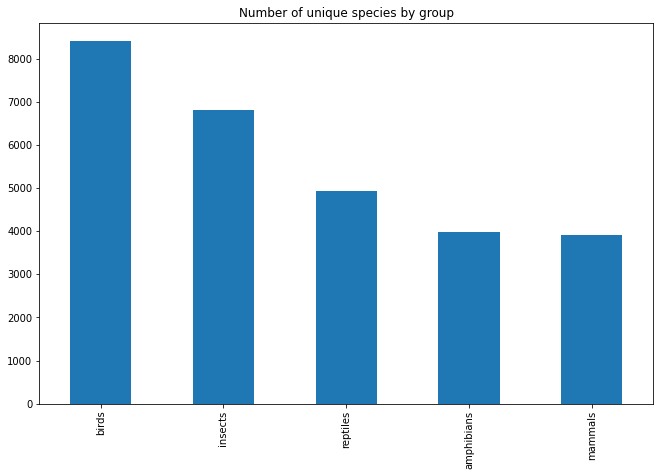

In [21]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by group')
species.group.value_counts().plot(kind='bar')
plt.show()

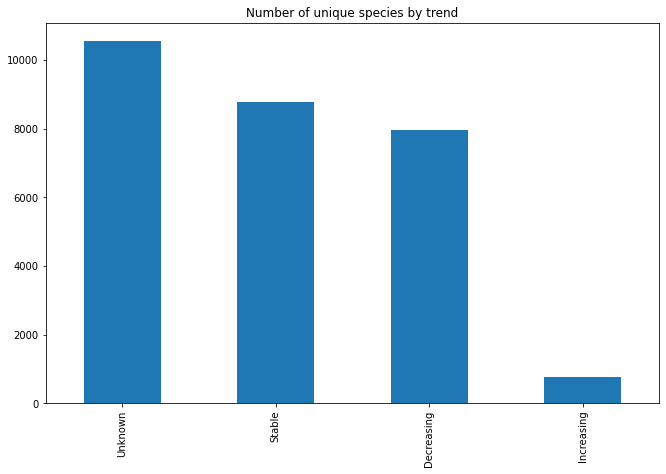

In [22]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by trend')
species.trend.value_counts().plot(kind='bar')
plt.show()

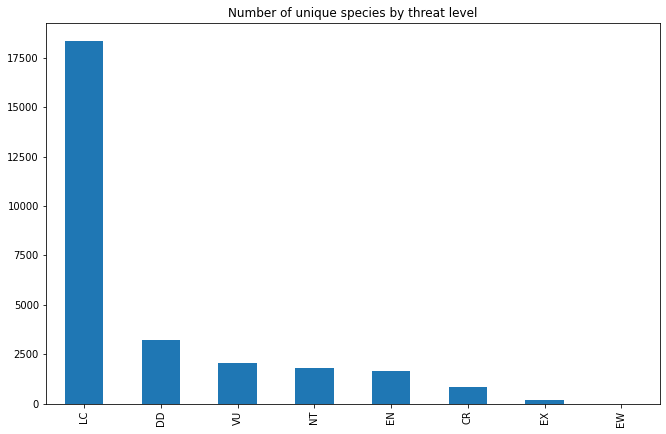

In [23]:
fig, ax = plt.subplots(figsize=(11, 7))
ax.set_title('Number of unique species by threat level')
species.threat_level.value_counts().plot(kind='bar')
plt.show()

## Evaluate reason for missing trends
It can be seen above that a significant portion of the trends are classified as 'Unknown'. Here we will analyse how these are distributed to be able to conclude if and how the predictions for the trends may be impeded.

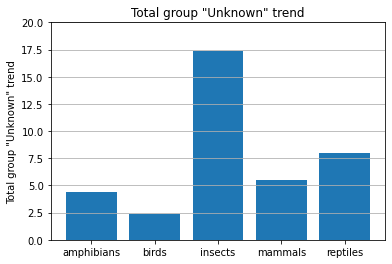

In [24]:
miss_trend = species[species.trend == 'Unknown'].sort_values('group')

miss_trend_group = miss_trend.drop(['threat_level'], axis=1)

miss_trend_group = miss_trend_group.groupby(['trend', 'group']).count().scientific_name
total_group = species.sort_values('group').groupby(['group']).count().scientific_name

plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(total_group) * 100)
plt.title('Total group "Unknown" trend')
plt.ylabel('Total group "Unknown" trend')
plt.ylim(0,20)
plt.grid(axis='y')
plt.show()

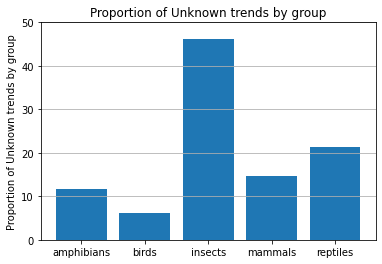

In [25]:
plt.bar(species.sort_values('group').group.unique(), miss_trend_group / sum(miss_trend_group) * 100)
plt.title('Proportion of Unknown trends by group')
plt.ylabel('Proportion of Unknown trends by group')
plt.ylim(0,50)
plt.grid(axis='y')

plt.show()

In [26]:
# transform data
grouped = IUCN_cleaned_data.groupby(['Country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot_table(index='Country', columns='trend', values='count')
species_trend_country = species_trend_country.fillna(0.0)
species_trend_country['Total'] = species_trend_country.sum(axis=1)
species_trend_country.shape

miss_trend_country = species_trend_country.copy()
miss_trend_country['Percent_Unknown'] = miss_trend_country.Unknown / sum(miss_trend_group) * 100
miss_trend_country['Proportion_Unknown'] = miss_trend_country.Unknown / miss_trend_country.Total * 100

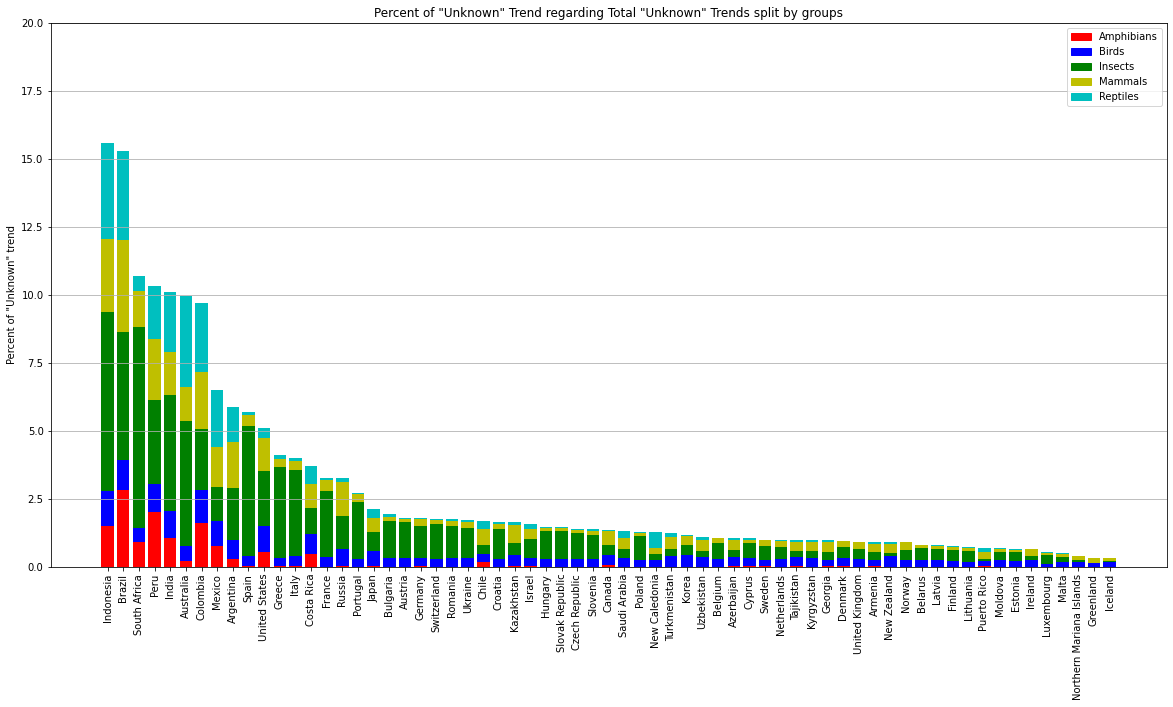

In [27]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['Country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('Country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Percent_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Percent_Unknown'] = miss_tcg_amphibians['count'] / sum(miss_trend_group) * 100
miss_tcg_birds['Percent_Unknown'] = miss_tcg_birds['count'] / sum(miss_trend_group) * 100
miss_tcg_insects['Percent_Unknown'] = miss_tcg_insects['count'] / sum(miss_trend_group) * 100
miss_tcg_mammals['Percent_Unknown'] = miss_tcg_mammals['count'] / sum(miss_trend_group) * 100
miss_tcg_reptiles['Percent_Unknown'] = miss_tcg_reptiles['count'] / sum(miss_trend_group) * 100

countries = ind.reset_index()['Country']

amphibians = miss_tcg_amphibians['Percent_Unknown'].values
birds = miss_tcg_birds['Percent_Unknown'].values
insects = miss_tcg_insects['Percent_Unknown'].values
mammals = miss_tcg_mammals['Percent_Unknown'].values
reptiles = miss_tcg_reptiles['Percent_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend regarding Total "Unknown" Trends split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,20)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)
plt.grid(axis='y')

plt.show()

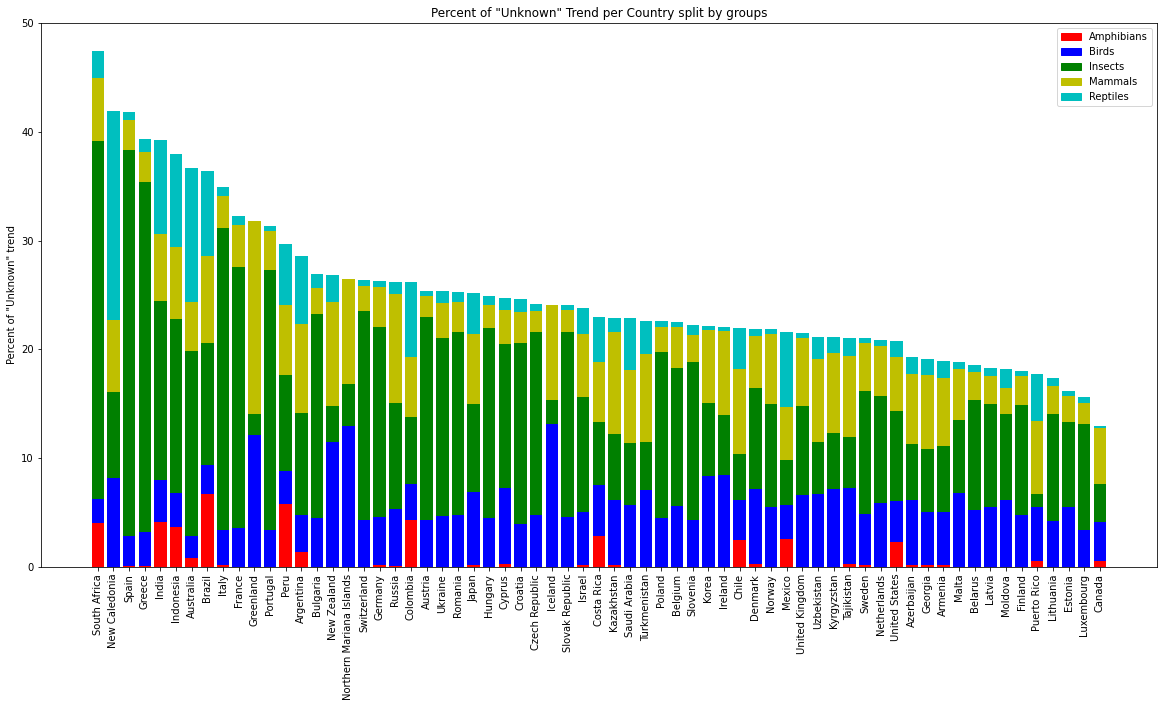

In [30]:
miss_trend_country_group = IUCN_cleaned_data[IUCN_cleaned_data.trend=='Unknown'].groupby(['Country', 'group'])['scientific_name'].count().reset_index(name='count')

miss_trend_country_group = miss_trend_country_group.set_index('Country')

ind = miss_trend_country.drop(['Decreasing', 'Increasing', 'Stable'], axis=1).sort_values('Proportion_Unknown', ascending=False)

miss_tcg_amphibians = miss_trend_country_group[miss_trend_country_group.group == 'amphibians']
miss_tcg_birds = miss_trend_country_group[miss_trend_country_group.group == 'birds']
miss_tcg_insects = miss_trend_country_group[miss_trend_country_group.group == 'insects']
miss_tcg_mammals = miss_trend_country_group[miss_trend_country_group.group == 'mammals']
miss_tcg_reptiles = miss_trend_country_group[miss_trend_country_group.group == 'reptiles']

miss_tcg_amphibians = pd.concat([ind, miss_tcg_amphibians], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_birds = pd.concat([ind, miss_tcg_birds], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_insects = pd.concat([ind, miss_tcg_insects], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_mammals = pd.concat([ind, miss_tcg_mammals], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)
miss_tcg_reptiles = pd.concat([ind, miss_tcg_reptiles], axis=1).fillna(0).drop(['Unknown', 'group'], axis=1)

miss_tcg_amphibians['Proportion_Unknown'] = miss_tcg_amphibians['count'] / miss_tcg_amphibians.Total * 100
miss_tcg_birds['Proportion_Unknown'] = miss_tcg_birds['count'] / miss_tcg_birds.Total * 100
miss_tcg_insects['Proportion_Unknown'] = miss_tcg_insects['count'] / miss_tcg_insects.Total * 100
miss_tcg_mammals['Proportion_Unknown'] = miss_tcg_mammals['count'] / miss_tcg_mammals.Total * 100
miss_tcg_reptiles['Proportion_Unknown'] = miss_tcg_reptiles['count'] / miss_tcg_reptiles.Total * 100

countries = ind.reset_index()['Country']

amphibians = miss_tcg_amphibians['Proportion_Unknown'].values
birds = miss_tcg_birds['Proportion_Unknown'].values
insects = miss_tcg_insects['Proportion_Unknown'].values
mammals = miss_tcg_mammals['Proportion_Unknown'].values
reptiles = miss_tcg_reptiles['Proportion_Unknown'].values

plt.figure(figsize=(20,10))
plt.bar(countries, amphibians, color='r')
plt.bar(countries, birds, bottom=amphibians, color='b')
plt.bar(countries, insects, bottom=birds + amphibians, color='g')
plt.bar(countries, mammals, bottom=insects + birds + amphibians, color='y')
plt.bar(countries, reptiles, bottom=mammals + insects + birds + amphibians, color='c')

plt.title('Percent of "Unknown" Trend per Country split by groups')
plt.xticks(rotation='vertical')
plt.ylim(0,50)
plt.ylabel('Percent of "Unknown" trend')

colors = {'Amphibians':'r', 'Birds':'b', 'Insects':'g', 'Mammals':'y', 'Reptiles':'c'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

It can be seen, that most of the missing values can be atributed to insects and reptiles, this can influence the predictions for this groups.
Regarding distribution amoung countries, some countries with a higher biodiversity have a larger share of missing values. 
When comparing the unknown trends amoung the other trends inside the country most countries have around 20-40 Percent of entries categorized as "Unknown", therefore we don't expect a difference in predictability coming from the countries.


# Support Data Preparation
## World Bank Climate
The climate dataset was obtained from [The World Bank Group](https://climateknowledgeportal.worldbank.org/download-data). 
Sadly there was no data accessible for the climate of 2020. 
Thus we had to work with data from 1990 to 2016 which was available. 
Because the data wasn't completely representative for the year 2020, we tried to extract features of the temperature growth.
### Constants

In [31]:
TEMP_DATA = 'data/climate/temperature_data_1991_2016.csv'
RAIN_DATA = 'data/climate/rain_data_1991_2016.csv'
OUTPUT_PATH = 'data/climate/climate_features.csv'

### Temperature Data
#### Load and Transform Data

In [32]:
data_temp = pd.read_csv(
    TEMP_DATA,
    sep=',',
    names=['Temperature', 'Year', 'Statistics', 'Country', 'ISO_Country',
           '_']).drop(0)
data_temp['Month'] = data_temp['Statistics'].apply(lambda x: x.split()[0])
data_temp['Country'] = data_temp['Country'].apply(lambda x: x.lstrip())
data_temp['Temperature'] = data_temp['Temperature'].astype(float)
data_temp['Year'] = data_temp['Year'].astype(int)
data_temp = data_temp[['Temperature', 'Year', 'Month', 'Country']]

### Overview

In [33]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61152 entries, 1 to 61152
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  61152 non-null  float64
 1   Year         61152 non-null  int64  
 2   Month        61152 non-null  object 
 3   Country      61152 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB


#### Temperature

count    61152.000000
mean        19.224302
std         10.136161
min        -30.859000
25%         13.824000
50%         23.322650
75%         26.244025
max         38.566900
Name: Temperature, dtype: float64

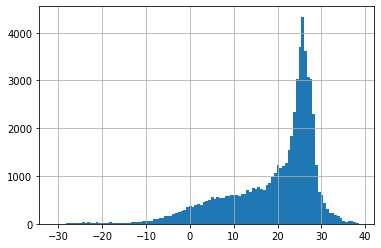

In [34]:
data_temp['Temperature'].hist(bins='auto')
data_temp['Temperature'].describe()

#### Year

count    61152.000000
mean      2003.500000
std          7.500061
min       1991.000000
25%       1997.000000
50%       2003.500000
75%       2010.000000
max       2016.000000
Name: Year, dtype: float64

<AxesSubplot:>

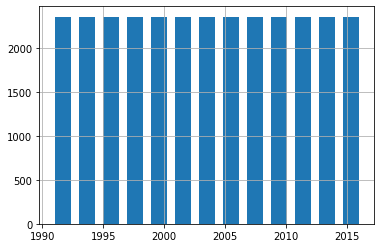

In [35]:
display(data_temp['Year'].describe())
data_temp['Year'].hist(bins='auto')

#### Month

count     61152
unique       12
top         Sep
freq       5096
Name: Month, dtype: object

<AxesSubplot:>

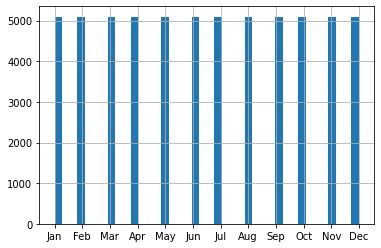

In [36]:
display(data_temp['Month'].describe())
data_temp['Month'].hist(bins='auto')

#### Country

In [37]:
display(data_temp['Country'].describe())

count     61152
unique      195
top       Korea
freq        624
Name: Country, dtype: object

In [38]:
# Check if data contains all Countries we have in our country list
set(SELECTED_COUNTRIES).difference(set(data_temp['Country'].unique()))

{'Slovak Republic'}

In [39]:
# --> Slovakia has to be renamed to Slovak Republic
data_temp.loc[data_temp['Country'] == 'Slovakia', 'Country'] = 'Slovak Republic'
set(SELECTED_COUNTRIES).difference(set(data_temp['Country'].unique()))

set()

### Rainfall Data
#### Load and Transform Data

In [40]:
data_rain = pd.read_csv(RAIN_DATA, sep=',',
    names=['Rainfall', 'Year', 'Statistics', 'Country', 'ISO_Country',
           '_']).drop(0)
data_rain['Rainfall'] = data_rain['Rainfall'].astype(float)
data_rain['Month'] = data_rain['Statistics'].apply(lambda x: x.split()[0])
data_rain['Country'] = data_rain['Country'].apply(lambda x: x.lstrip())
data_rain['Year'] = data_rain['Year'].astype(int)

### Overview

In [41]:
data_rain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61152 entries, 1 to 61152
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rainfall     61152 non-null  float64
 1   Year         61152 non-null  int64  
 2   Statistics   61152 non-null  object 
 3   Country      61152 non-null  object 
 4   ISO_Country  61152 non-null  object 
 5   _            1560 non-null   object 
 6   Month        61152 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 3.7+ MB


### Rainfall

count    61152.000000
mean       103.581125
std        114.130057
min          0.000000
25%         24.123175
50%         66.192300
75%        149.172000
max       2699.190000
Name: Rainfall, dtype: float64

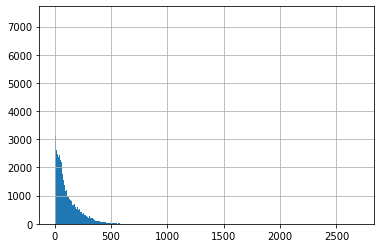

In [42]:
data_rain['Rainfall'].hist(bins='auto')
data_rain['Rainfall'].describe()

#### Year 

count    61152.000000
mean      2003.500000
std          7.500061
min       1991.000000
25%       1997.000000
50%       2003.500000
75%       2010.000000
max       2016.000000
Name: Year, dtype: float64

<AxesSubplot:>

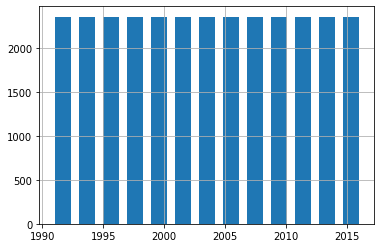

In [43]:
display(data_rain['Year'].describe())
data_rain['Year'].hist(bins='auto')

#### Month

count     61152
unique       12
top         Sep
freq       5096
Name: Month, dtype: object

<AxesSubplot:>

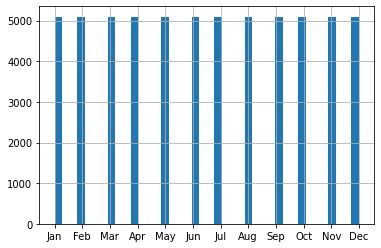

In [44]:
display(data_rain['Month'].describe())
data_rain['Month'].hist(bins='auto')

#### Country

In [45]:
# Check if data contains all Countries we have in our country list
set(SELECTED_COUNTRIES).difference(set(data_rain['Country'].unique()))

{'Slovak Republic'}

In [46]:
# --> Slovakia has to be renamed to Slovak Republic
data_rain.loc[data_rain['Country'] == 'Slovakia', 'Country'] = 'Slovak Republic'
set(SELECTED_COUNTRIES).difference(set(data_rain['Country'].unique()))

set()

### Merge Datasets
#### Check if Countries, Years and Months are identical

In [47]:
country_temp = set(data_temp['Country'].unique())
country_rain = set(data_rain['Country'].unique())
print('Matching country keys: {}'.format(country_temp == country_rain))

Matching country keys: True


In [48]:
year_temp = set(data_temp['Year'].unique())
year_rain = set(data_rain['Year'].unique())
print('Matching country keys: {}'.format(year_temp == year_rain))

Matching country keys: True


In [49]:
month_temp = set(data_temp['Month'].unique())
month_rain = set(data_rain['Month'].unique())
print('Matching country keys: {}'.format(month_temp == month_rain))

Matching country keys: True


#### Merge

In [50]:
data_full = data_temp.merge(data_rain)

### Show change over time for all countries averaged
#### GroupBy Year and Country

In [51]:
by_year = data_full.groupby(['Year', 'Country']).agg(np.mean).reset_index()

#### Only show OECD Countries

In [52]:
by_year = by_year[by_year['Country'].isin(SELECTED_COUNTRIES)]

#### Plot Average Temperature by Country over Time

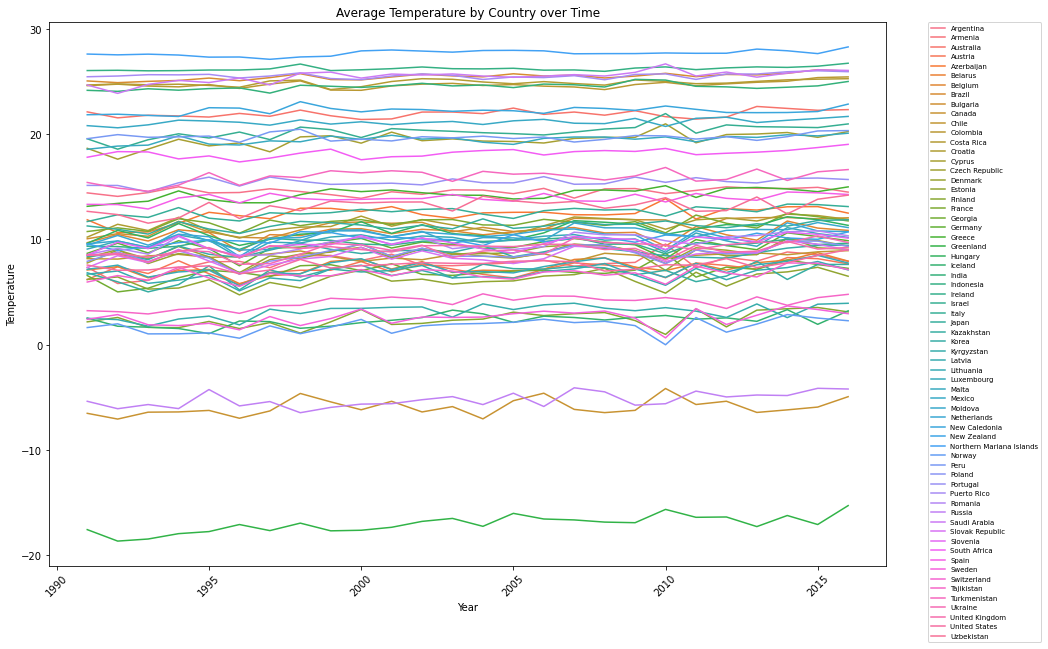

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Average Temperature by Country over Time')

sns.lineplot(data=by_year.reset_index(),
             x='Year',
             y='Temperature',
             hue='Country')
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)

plt.show()

There is low variance in the temperature of the last 30 years. As we don't get any data in better quality (and from 2020), we have to extract features out of this dataset and use it as support data. 

#### Plot Average Rainfall by Country over Time

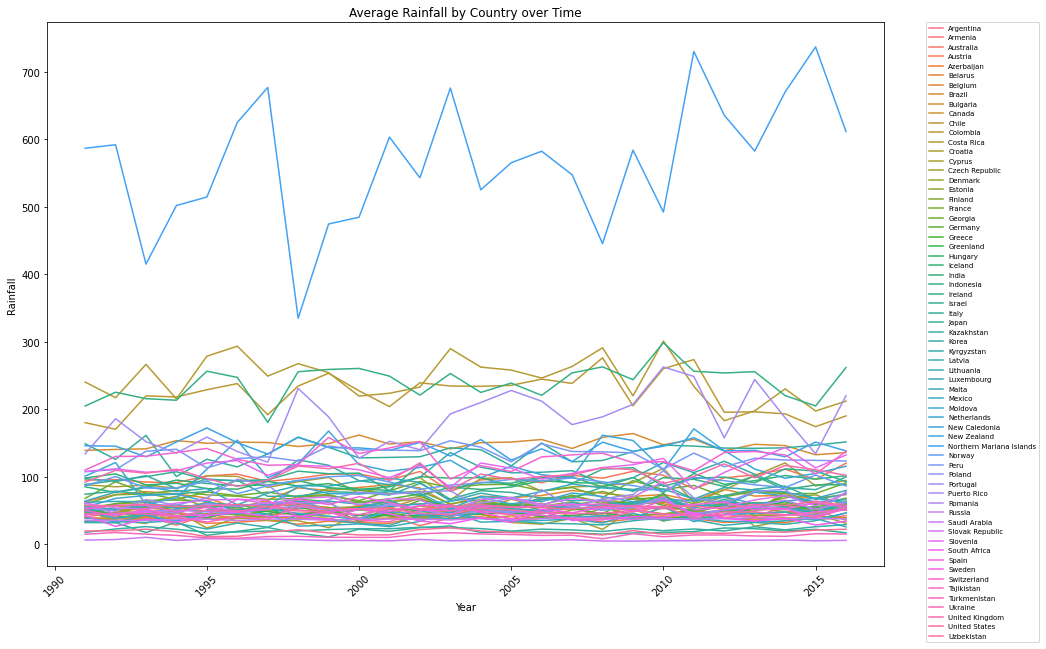

In [54]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Average Rainfall by Country over Time')

sns.lineplot(data=by_year.reset_index(),
             x='Year',
             y='Rainfall',
             hue='Country')
plt.xticks(rotation=45)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)

plt.show()

The rainfall for a particular country doesn't seem to be as stable as the temperature. As we have a lot of other different support data sets, we are going to discard this feature.

### Extract Temperature Features

In [55]:
features = pd.DataFrame(data_full['Country'].unique(), columns=['Country'])

## fit regression line to data
def extract_slope(x, y):
    m, b = np.polyfit(x, y, 1)
    return m

## extract percentual temperature gain from first to last year
def extract_gain_percentage(country_df, past_years=1):

    min_year = country_df['Year'].min()
    start_mean_temp = country_df[country_df['Year'] ==
                                 min_year]['Temperature'].mean()

    max_year = country_df['Year'].max()

    past_years_mean_temp = country_df[country_df['Year'] > (
        max_year - past_years)]['Temperature'].mean()

    return (past_years_mean_temp / start_mean_temp - 1) * 100

## extract absolute temperature difference from first to last year
def extract_difference(country_df, past_years=1):
    min_year = country_df['Year'].min()
    start_mean_temp = country_df[country_df['Year'] ==
                                 min_year]['Temperature'].mean()

    max_year = country_df['Year'].max()

    past_years_mean_temp = country_df[country_df['Year'] > (
        max_year - past_years)]['Temperature'].mean()

    return past_years_mean_temp - start_mean_temp 

for country in features['Country'].unique():
    sel_c = data_full.loc[data_full['Country'] == country, :]
    
    ## extract temperature slope
    features.loc[features['Country'] == country,
                 'temp_slope'] = extract_slope(sel_c['Year'],
                                               sel_c['Temperature'])
    ## extract temperature gain percentage
    features.loc[features['Country'] == country,
                 'gain_percentage'] = extract_gain_percentage(sel_c)
    
    ## extract temperature difference
    features.loc[features['Country'] == country,
                 'temp_difference'] = extract_difference(sel_c)
    

In [56]:
ds_climate = features.copy()

## Greenhouse gasses
The greenhouse gases were taken as a dataset, because of our believe, that the output of greenhouse gasses can decrease the survivability in the region. 
We used the openly available dataset from the OECD that can be downloaded from https://stats.oecd.org/Index.aspx?DataSetCode=AIR_GHG
To normalize these values and make them comparable to each other we calculated the output per inhabitant. This makes large countries comparable to smaller countries. For this step we used the historic Population dataset from oecd (https://stats.oecd.org/Index.aspx?DataSetCode=HISTPOP)


### Load Data

In [58]:
AIR_GHG = DATA_PATH / 'OECD' / 'AIR_GHG.csv'
df = pd.read_csv(AIR_GHG)

### Cleaning Data
#### Resolve Power

In [59]:
df.Value = df.Value * 10 **  df['PowerCode Code']

#### Filter only for totals

In [60]:
df = df[df['VAR'] == 'TOTAL']

#### Drop Estimates

In [61]:
df = df[df['Flag Codes'].isnull()]

#### Delete unneaded columns

In [62]:
df = df.drop(labels=['COU','Pollutant', 'VAR', 'Variable', 'Year', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags'], axis=1)

#### Delete old Data (< 2005)

In [63]:
df = df[df.YEA > 2005]

### Feature Preperation
#### Normalize Data

In [65]:
HISTPOP = DATA_PATH / 'OECD' / 'HISTPOP.csv'

pop = pd.read_csv(HISTPOP)
pop = pop[pop.SEX == 'T']
pop = pop[pop.AGE == 'TOTAL']

for i in df.index:
    ctr = df['Country'][i]
    yea = df['YEA'][i]
    norm = pop[(pop.Country == ctr) & (pop.Time == yea)].Value
    if norm.empty:
        norm = 1.0
    
    df['Value'][i]=  df['Value'][i] / norm

#### Transform data into years

In [66]:
df = df.pivot(index=['Country', 'POL'], columns='YEA', values=['Value']).reset_index()

df['2019'] = np.NaN
df['2020'] = np.NaN

#### Extract Polution Type

In [67]:
CH4 = df[df['POL'] == 'CH4']
CO2 = df[df['POL'] == 'CO2']
HFC = df[df['POL'] == 'HFC']
HFC_PFC = df[df['POL'] == 'HFC_PFC']
N2O = df[df['POL'] == 'N2O']
NF3 = df[df['POL'] == 'NF3']
PFC = df[df['POL'] == 'PFC']
SF6 = df[df['POL'] == 'SF6']

CH4 = CH4.drop(labels=['POL'], axis=1)
CO2 = CO2.drop(labels=['POL'], axis=1)
HFC = HFC.drop(labels=['POL'], axis=1)
HFC_PFC = HFC_PFC.drop(labels=['POL'], axis=1)
N2O = N2O.drop(labels=['POL'], axis=1)
NF3 = NF3.drop(labels=['POL'], axis=1)
PFC = PFC.drop(labels=['POL'], axis=1)
SF6 = SF6.drop(labels=['POL'], axis=1)

### Analysis of previous Years

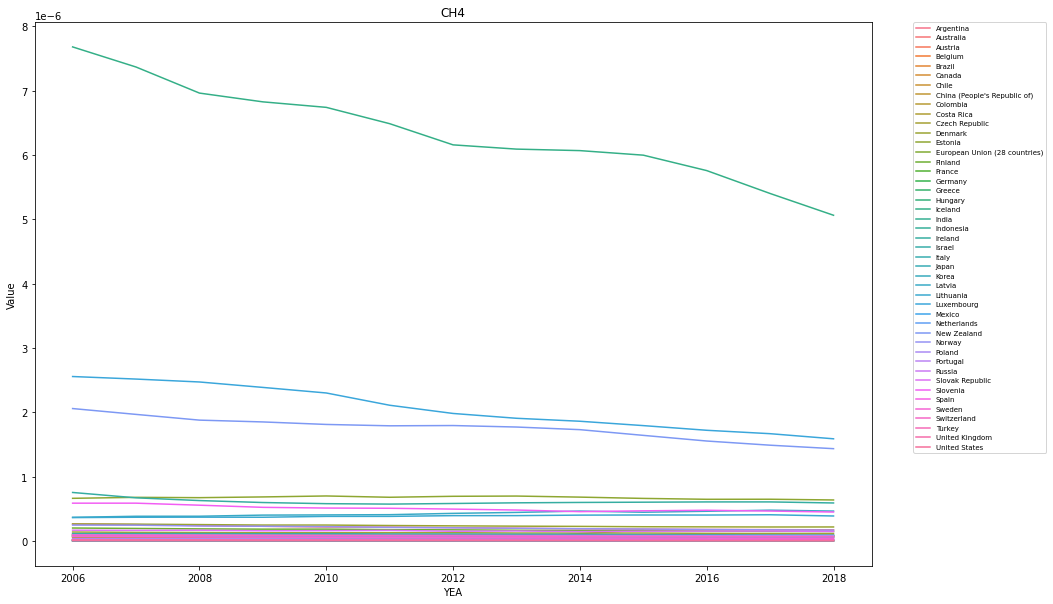

In [68]:
CH4_plot = CH4.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
CH4_plot = CH4_plot[CH4_plot.YEA != '']
CH4_plot = CH4_plot[~pd.to_numeric(CH4_plot['Value'], errors='coerce').isnull()]
CH4_plot.Value = CH4_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('CH4')

sns.lineplot(
    data=CH4_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

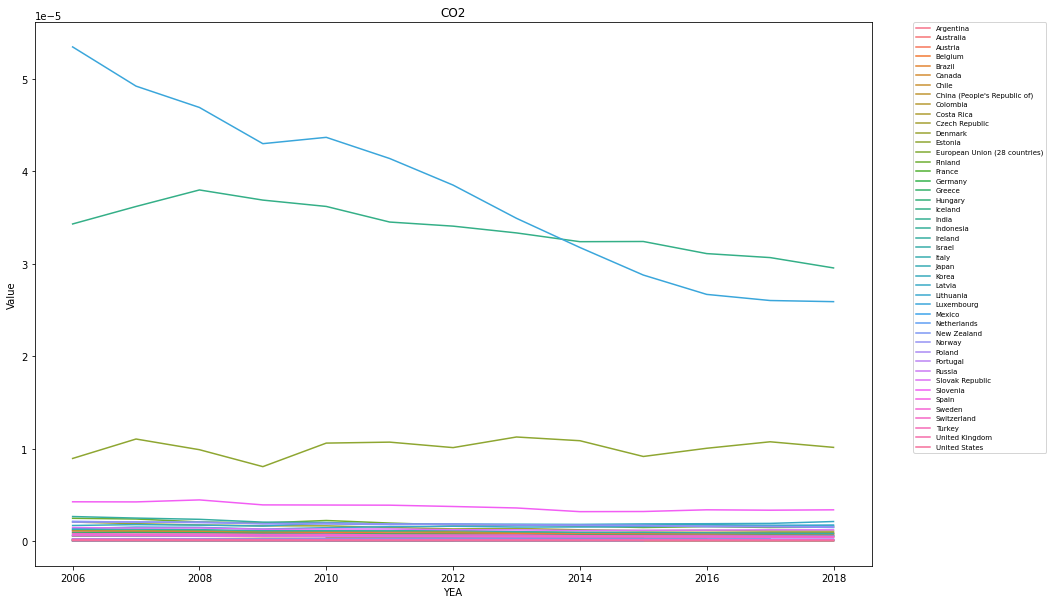

In [69]:
CO2_plot = CO2.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
CO2_plot = CO2_plot[CO2_plot.YEA != '']
CO2_plot = CO2_plot[~pd.to_numeric(CO2_plot['Value'], errors='coerce').isnull()]
CO2_plot.Value = CO2_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('CO2')

sns.lineplot(
    data=CO2_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

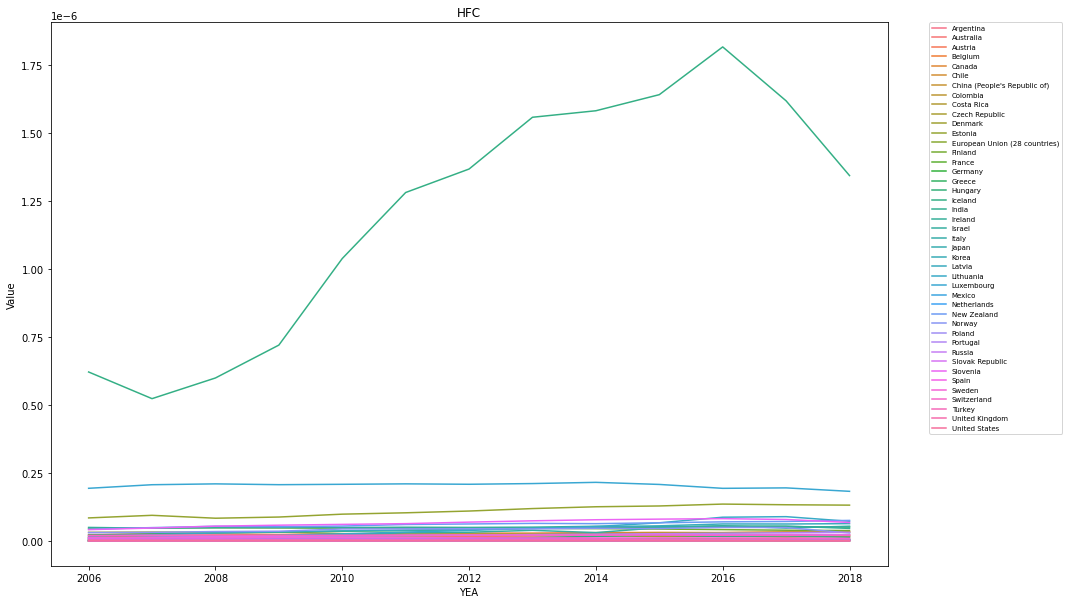

In [70]:
HFC_plot = HFC.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
HFC_plot = HFC_plot[HFC_plot.YEA != '']
HFC_plot = HFC_plot[~pd.to_numeric(HFC_plot['Value'], errors='coerce').isnull()]
HFC_plot.Value = HFC_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('HFC')

sns.lineplot(
    data=HFC_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

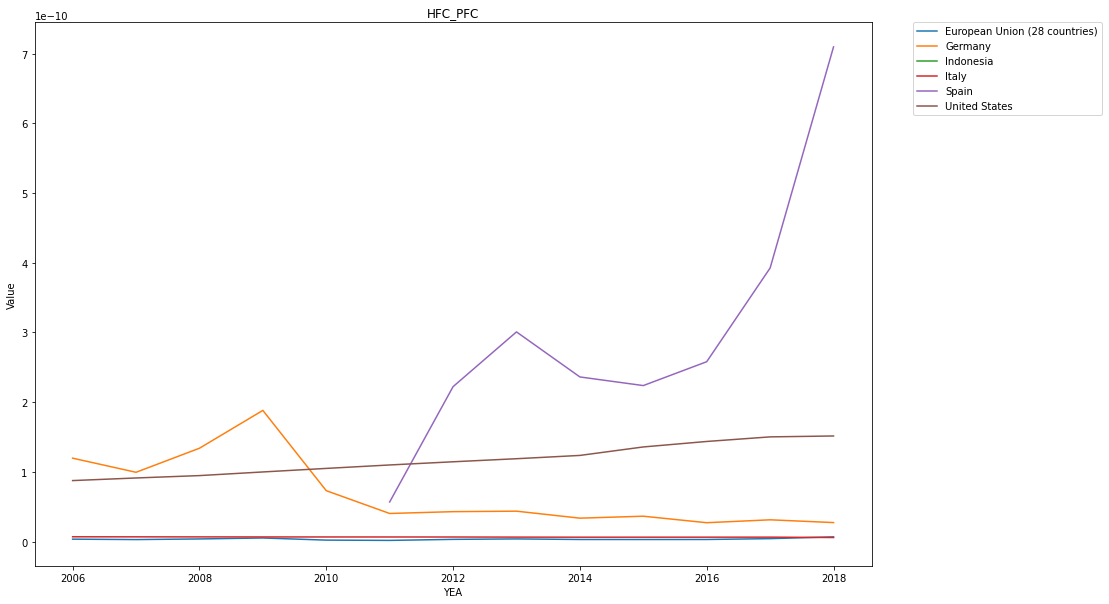

In [71]:
HFC_PFC_plot = HFC_PFC.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
HFC_PFC_plot = HFC_PFC_plot[HFC_PFC_plot.YEA != '']
HFC_PFC_plot = HFC_PFC_plot[~pd.to_numeric(HFC_PFC_plot['Value'], errors='coerce').isnull()]
HFC_PFC_plot.Value = HFC_PFC_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('HFC_PFC')

sns.lineplot(
    data=HFC_PFC_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

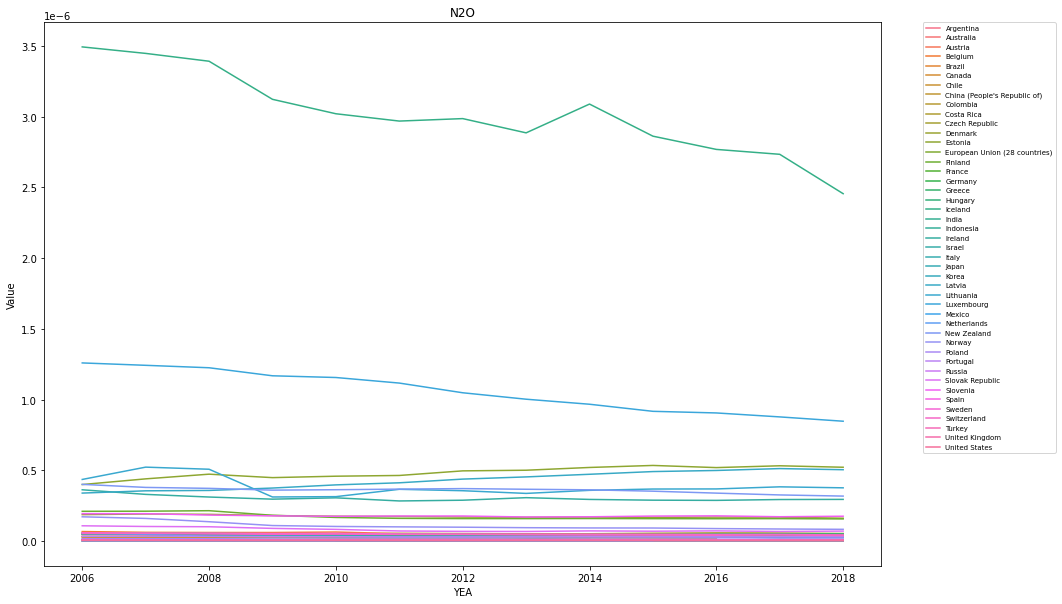

In [72]:
N2O_plot = N2O.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
N2O_plot = N2O_plot[N2O_plot.YEA != '']
N2O_plot = N2O_plot[~pd.to_numeric(N2O_plot['Value'], errors='coerce').isnull()]
N2O_plot.Value = N2O_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('N2O')

sns.lineplot(
    data=N2O_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

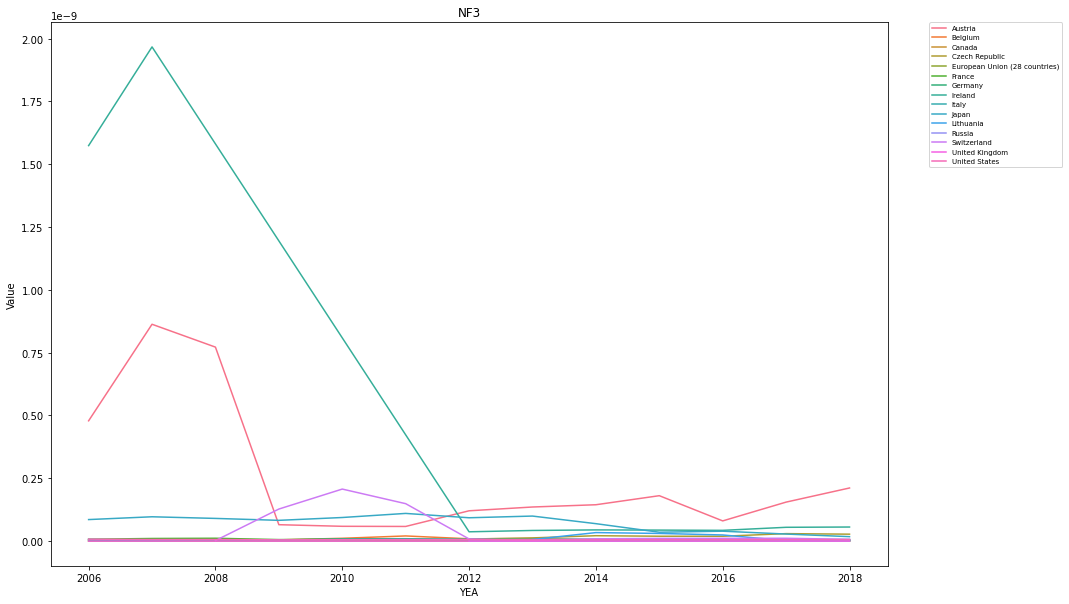

In [73]:
NF3_plot = NF3.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
NF3_plot = NF3_plot[NF3_plot.YEA != '']
NF3_plot = NF3_plot[~pd.to_numeric(NF3_plot['Value'], errors='coerce').isnull()]
NF3_plot.Value = NF3_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('NF3')

sns.lineplot(
    data=NF3_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

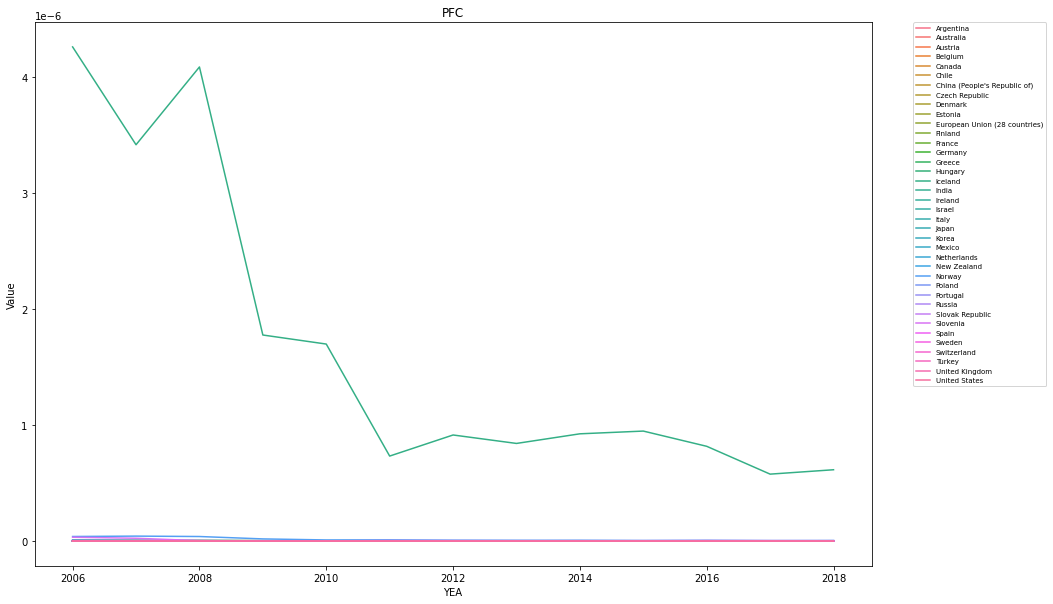

In [74]:
PFC_plot = PFC.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
PFC_plot = PFC_plot[PFC_plot.YEA != '']
PFC_plot = PFC_plot[~pd.to_numeric(PFC_plot['Value'], errors='coerce').isnull()]
PFC_plot.Value = PFC_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('PFC')

sns.lineplot(
    data=PFC_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

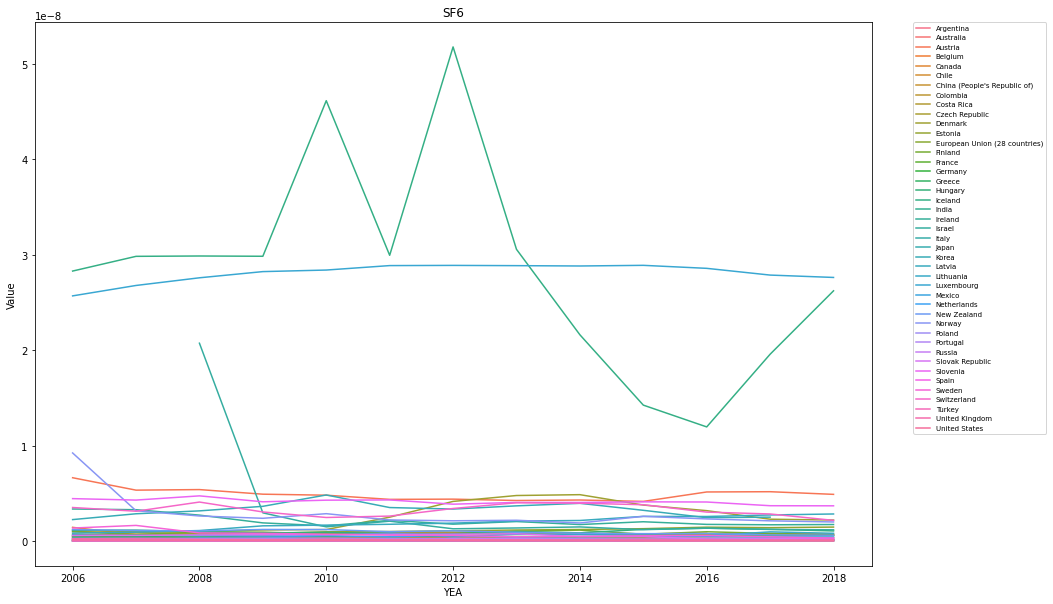

In [75]:
SF6_plot = SF6.set_index('Country').stack().reset_index().drop(['2019', '2020'], axis=1)
SF6_plot = SF6_plot[SF6_plot.YEA != '']
SF6_plot = SF6_plot[~pd.to_numeric(SF6_plot['Value'], errors='coerce').isnull()]
SF6_plot.Value = SF6_plot.Value.astype(float)

f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('SF6')

sns.lineplot(
    data=SF6_plot,
    x='YEA',
    y='Value',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

Most of the values where stable for a country the resent years. Because of this we decided, that the most recent value per country per greenhouse gas can be used as the current Value.
Additionally we decided can use all features except the HFC_PFC in the next steps. HFC_PFC was discarded, as only 6 Countries had mesasurements for this type.
For all other measurements it was decided to replace missing values with -1 to be usable and differentiable in the next steps.

### Autofill 2020

In [76]:
CH4 = CH4.transpose().fillna(method='ffill').transpose()
CO2 = CO2.transpose().fillna(method='ffill').transpose()
HFC = HFC.transpose().fillna(method='ffill').transpose()
HFC_PFC = HFC_PFC.transpose().fillna(method='ffill').transpose()
N2O = N2O.transpose().fillna(method='ffill').transpose()
NF3 = NF3.transpose().fillna(method='ffill').transpose()
PFC = PFC.transpose().fillna(method='ffill').transpose()
SF6 = SF6.transpose().fillna(method='ffill').transpose()

conc = [
    CH4[['Country', '2020']].set_index('Country'),
    CO2[['Country', '2020']].set_index('Country'),
    HFC[['Country', '2020']].set_index('Country'),
    HFC_PFC[['Country', '2020']].set_index('Country'),
    N2O[['Country', '2020']].set_index('Country'),
    NF3[['Country', '2020']].set_index('Country'),
    PFC[['Country', '2020']].set_index('Country'),
    SF6[['Country', '2020']].set_index('Country'),
]

res = pd.concat(conc, axis=1, join='outer')
res.columns = ['CH4', 'CO2', 'HFC', 'HFC_PFC', 'N2O', 'NF3', 'PFC', 'SF6']

### Remove unclear columns (Columns with too many missing values)

In [77]:
res = res.drop('HFC_PFC', axis=1)
res = res.fillna(-1)

### Save Dataset

In [78]:
res = res.reset_index(drop=False)
res = res.rename(columns={'index':'Country'})

ds_ghg = res.copy()

## Land Cover
Data about land cover of several OECD and non OECD countries (https://stats.oecd.org/Index.aspx?DataSetCode=LAND_COVER#)

### Loading Data

In [80]:
LAND_COVER = DATA_PATH / 'OECD' / 'LAND_COVER_DATA.csv'
TOTAL_AREA =  DATA_PATH / 'Worldbank' / 'API_AG.SRF.TOTL.K2_DS2_en_csv_v2_1927208.csv'

land_cover = pd.read_csv(LAND_COVER)
land_cover.shape

(17694, 21)

In [81]:
land_cover.head()

COU    Country SMALL_SUBNATIONAL_REGION Small subnational region  \
0  AUS  Australia                    TOTAL                    Total   
1  AUS  Australia                    TOTAL                    Total   
2  AUS  Australia                    TOTAL                    Total   
3  AUS  Australia                    TOTAL                    Total   
4  AUS  Australia                    TOTAL                    Total   

  LARGE_SUBNATIONAL_REGION Large subnational region           MEAS  \
0                    TOTAL                    Total  THOUSAND_SQKM   
1                    TOTAL                    Total  THOUSAND_SQKM   
2                    TOTAL                    Total  THOUSAND_SQKM   
3                    TOTAL                    Total  THOUSAND_SQKM   
4                    TOTAL                    Total  THOUSAND_SQKM   

                     Measure VARIABLE Land cover class  ...  Year  Unit Code  \
0  Square kilometers (000's)   FOREST       Tree cover  ...  1992        NaN   
1  Square kilometers (000's)   FOREST       Tree cover  ...  2004        NaN   
2  Square kilometers (000's)   FOREST       Tree cover  ...  2015        NaN   
3  Square kilometers (000's)   FOREST       Tree cover  ...  2018        NaN   
4  Square kilometers (000's)     GRSL        Grassland  ...  1992        NaN   

   Unit  PowerCode Code  PowerCode Reference Period Code  Reference Period  \
0   NaN               0      Units                   NaN               NaN   
1   NaN               0      Units                   NaN               NaN   
2   NaN               0      Units                   NaN               NaN   
3   NaN               0      Units                   NaN               NaN   
4   NaN               0      Units                   NaN               NaN   

         Value  Flag Codes  Flags  
0   911.890687         NaN    NaN  
1   890.559607         NaN    NaN  
2   896.524077         NaN    NaN  
3   904.706598         NaN    NaN  
4  1205.405426         NaN    NaN  

[5 rows x 21 columns]

In [82]:
#number of unique values per column
land_cover.nunique()

COU                           246
Country                       246
SMALL_SUBNATIONAL_REGION        1
Small subnational region        1
LARGE_SUBNATIONAL_REGION        1
Large subnational region        1
MEAS                            2
Measure                         2
VARIABLE                        9
Land cover class                9
YEA                             4
Year                            4
Unit Code                       0
Unit                            0
PowerCode Code                  1
PowerCode                       1
Reference Period Code           0
Reference Period                0
Value                       12556
Flag Codes                      0
Flags                           0
dtype: int64

In [83]:
#for our analysis we use the relative data, to make it comparable across countries of different sizes
land_cover_rel = land_cover.copy()
land_cover_rel = land_cover_rel[land_cover_rel['MEAS'] == 'PCNT']
land_cover_rel.shape

(8838, 21)

## Cleaning Data

In [84]:
#we look at the unique countries (246 as shown before) in our new data frame 
land_cover_rel.Country.unique()

array(['Australia', 'Belgium', 'Canada', 'Czech Republic', 'Denmark',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Ireland', 'Italy', 'Japan', 'Luxembourg', 'Mexico', 'New Zealand',
       'Norway', 'Poland', 'Portugal', 'Slovak Republic', 'Spain',
       'Sweden', 'Switzerland', 'Turkey', 'United Kingdom',
       'United States', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Argentina', 'Aruba', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cabo Verde', 'Cayman Islands', 'Chad',
       "China (People's Republic of)", 'Comoros', 'Congo', 'Cook Islands',
       'Costa Rica', "Côte d'Ivoire", 'Croatia', 'Cuba', 'Cyprus',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Djibouti',
       'Dominica

In [85]:
#There are several entries that summarize a number of countries, which we remove
remove = ['OECD - Total','European Union (28 countries)','OECD - Europe','BRIICS economies - Brazil, Russia, India, Indonesia, China and South Africa','OECD Asia Oceania','OECD America','Latin America and Caribbean','Middle East and North Africa','G20']
land_cover_rel = land_cover_rel[~land_cover_rel['Country'].isin(remove)]
land_cover_rel.shape

(8514, 21)

In [86]:
#select subset of relevant columns Country, Year, Land cover class and Value
land_cover_rel = land_cover_rel[['Country', 'Year', 'Land cover class', 'Value']]
land_cover_rel.head()

Country  Year     Land cover class     Value
16  Australia  1992  Artificial surfaces  0.100015
17  Australia  2004  Artificial surfaces  0.136482
18  Australia  2015  Artificial surfaces  0.154930
19  Australia  2018  Artificial surfaces  0.159319
20  Australia  1992         Inland water  0.171305

In [87]:
#list of all land cover attributes
land_cover_rel['Land cover class'].unique()

array(['Artificial surfaces', 'Inland water', 'Bare area', 'Tree cover',
       'Shrubland', 'Sparse vegetation', 'Cropland', 'Wetland',
       'Grassland'], dtype=object)

In [88]:
#no missing values
land_cover_rel.isna().sum()
land_cover_rel

Country  Year     Land cover class      Value
16      Australia  1992  Artificial surfaces   0.100015
17      Australia  2004  Artificial surfaces   0.136482
18      Australia  2015  Artificial surfaces   0.154930
19      Australia  2018  Artificial surfaces   0.159319
20      Australia  1992         Inland water   0.171305
...           ...   ...                  ...        ...
17653       Sudan  2004             Cropland  20.276832
17658  Kazakhstan  1992         Inland water   6.825496
17659  Kazakhstan  2004         Inland water   6.486520
17660  Kazakhstan  2015         Inland water   6.214264
17661  Kazakhstan  2018         Inland water   6.247544

[8514 rows x 4 columns]

In [89]:
#setting year and country as index and our targets as columns
land_cover_rel = land_cover_rel.pivot_table(index=['Country','Year'],columns='Land cover class', values='Value')
land_cover_rel.columns.name = None
land_cover_rel.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country     Year                                                         
Afghanistan 1992             0.052857  39.283534  12.584400  36.040998   
            2004             0.081033  39.527342  12.131194  37.041703   
            2015             0.125987  39.126500  12.227564  37.305171   
            2018             0.144171  39.153980  12.120421  37.161205   
Albania     1992             0.607273   1.840586  54.521300   5.444811   

                  Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country     Year                                                           
Afghanistan 1992      0.405237   3.741778           6.647211    1.234941   
            2004      0.105870   3.547692           6.325024    1.229056   
            2015      0.099157   3.545375           6.330105    1.229056   
            2018      0.099181   3.545002           6.528826    1.236130   
Albania     1992      2.193421   3.337453           1.321790   30.452653   

                   Wetland  
Country     Year            
Afghanistan 1992  0.009044  
            2004  0.011085  
            2015  0.011085  
            2018  0.011085  
Albania     1992  0.280713

In [90]:
land_cover_rel.shape

(946, 9)

## Feature Preparation

In [91]:
#for better visualization, we only plot the values for the countries in our country list 
land_cover_OECD = land_cover_rel.loc[SELECTED_COUNTRIES]
land_cover_OECD.shape

(260, 9)

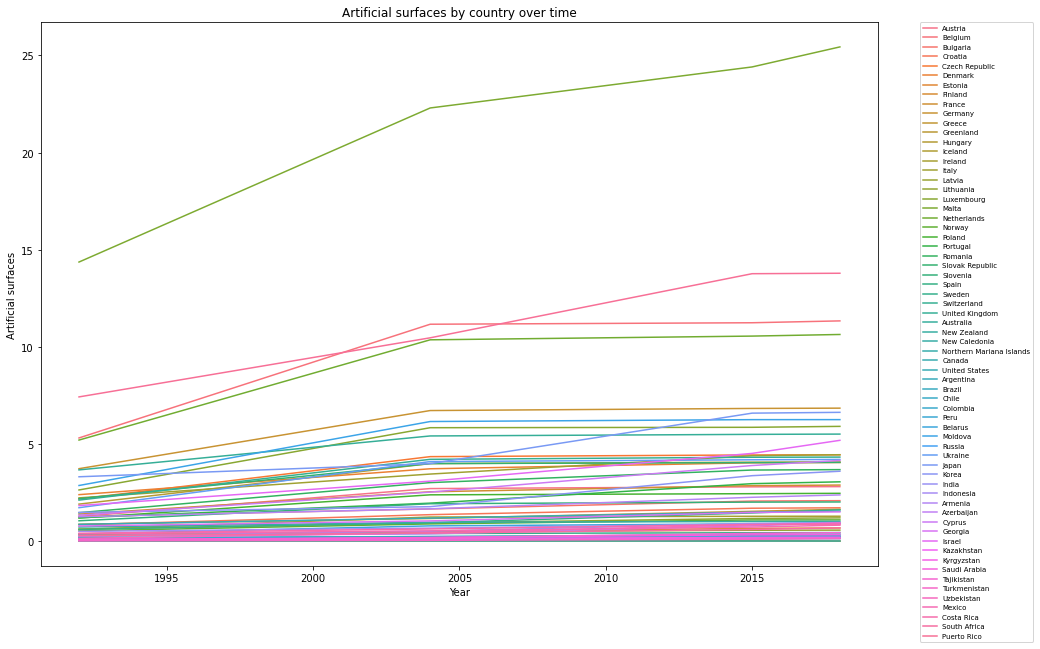

In [92]:
#plot the artifical surfaces over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Artificial surfaces by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Artificial surfaces',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

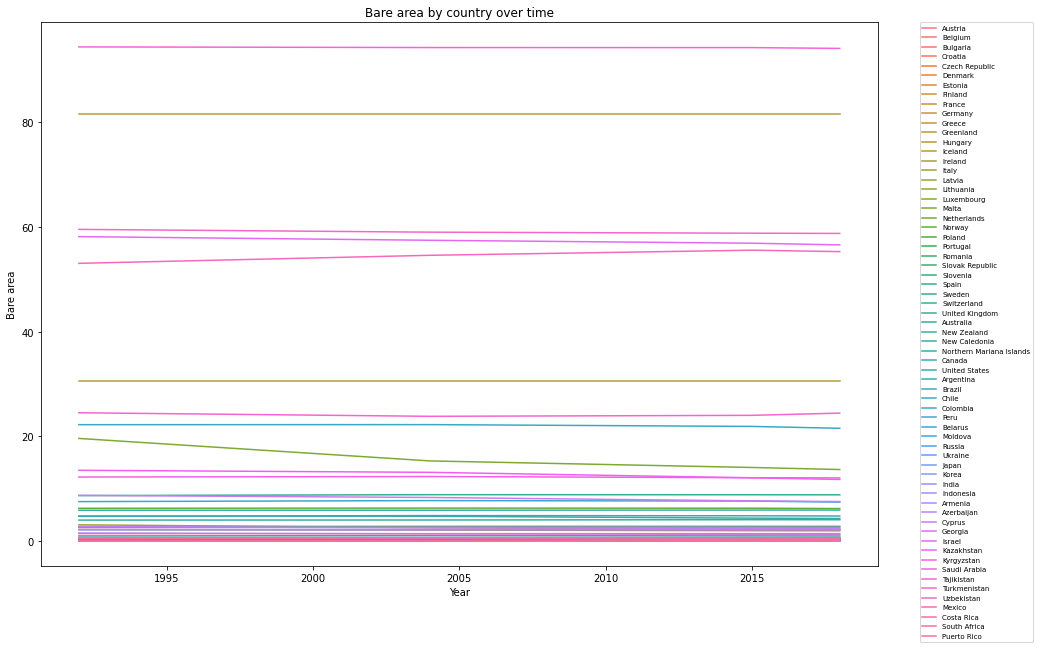

In [93]:
#plot the bare area over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Bare area by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Bare area',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

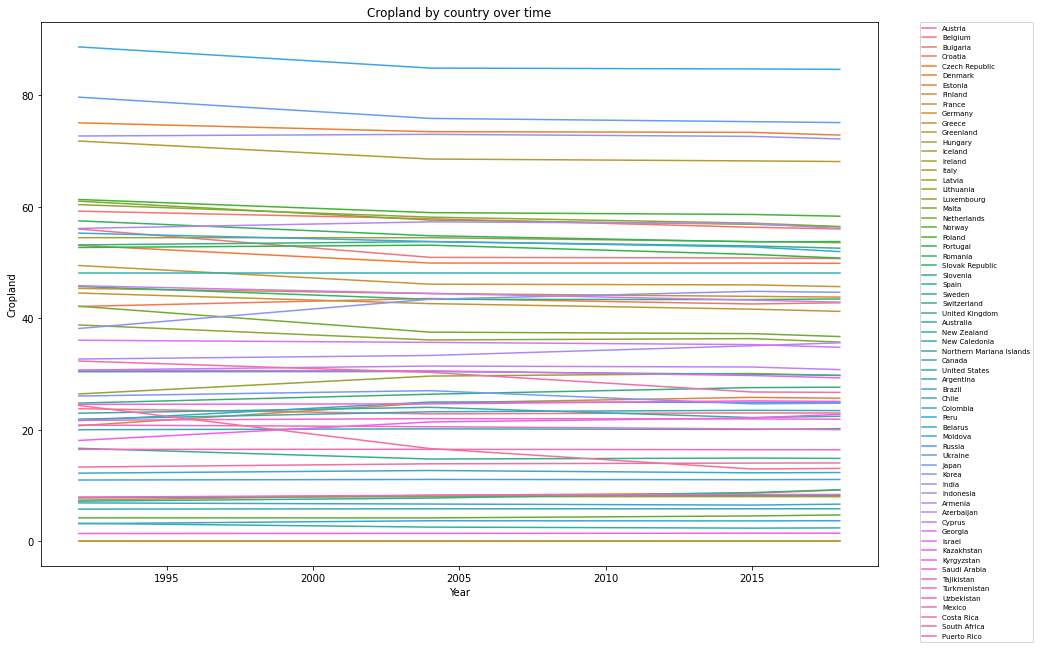

In [94]:
#plot the cropland over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Cropland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Cropland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

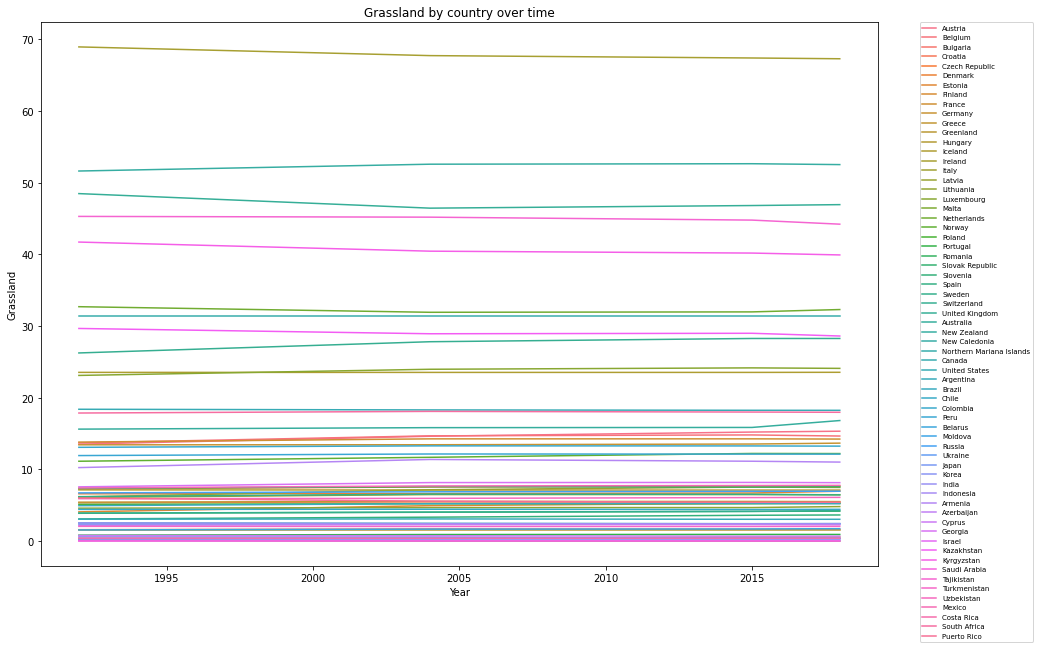

In [95]:
#plot the grassland over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Grassland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Grassland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

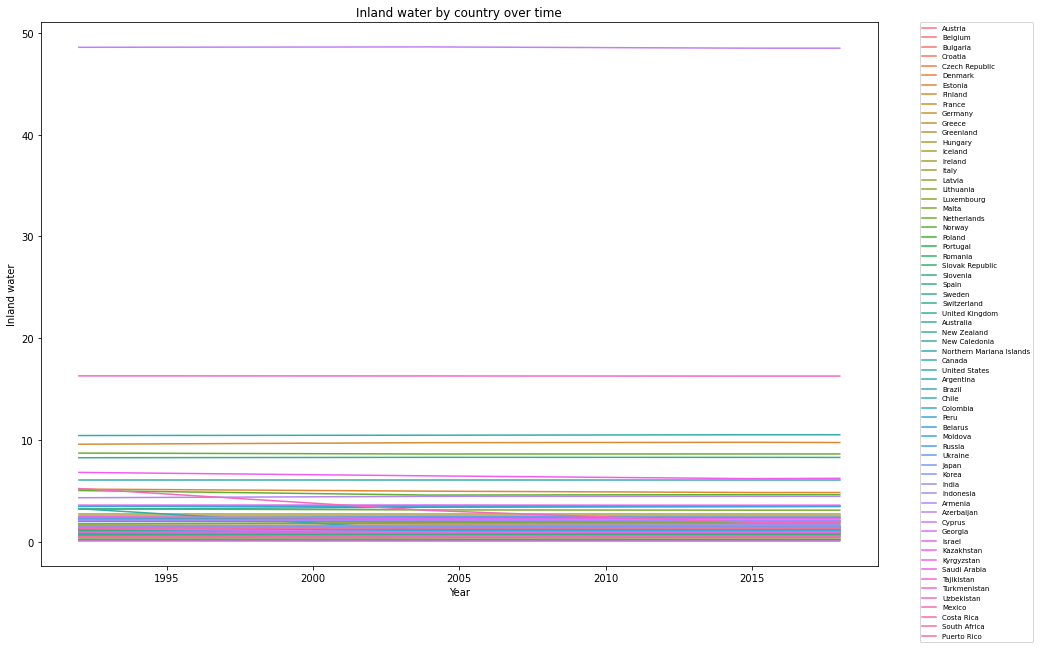

In [96]:
#plot the inland water over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Inland water by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Inland water',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

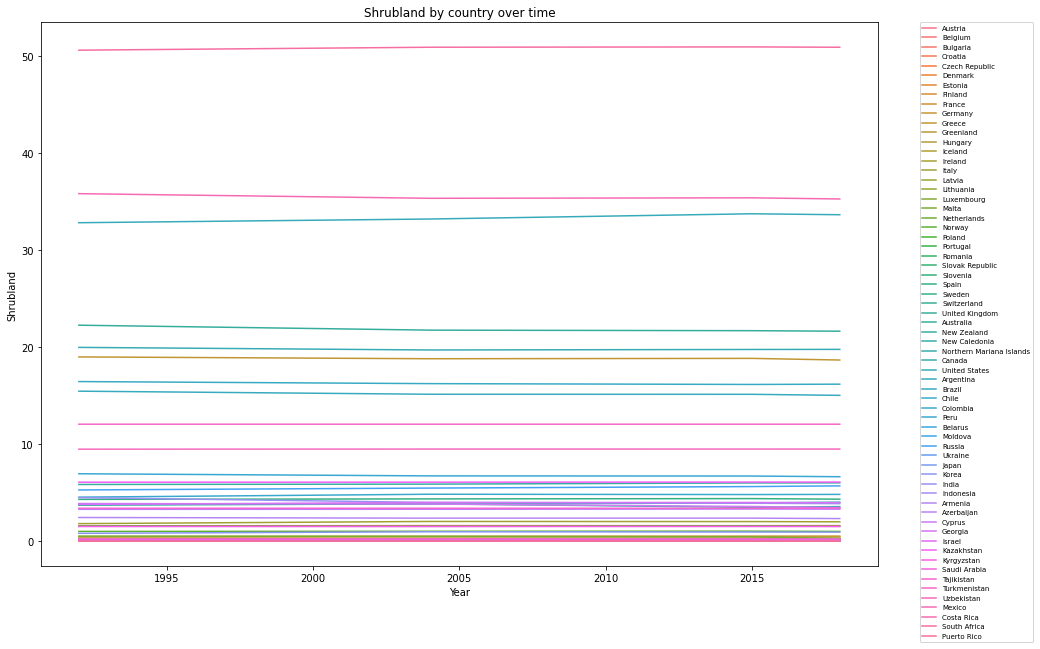

In [97]:
#plot the shrubland over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Shrubland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Shrubland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

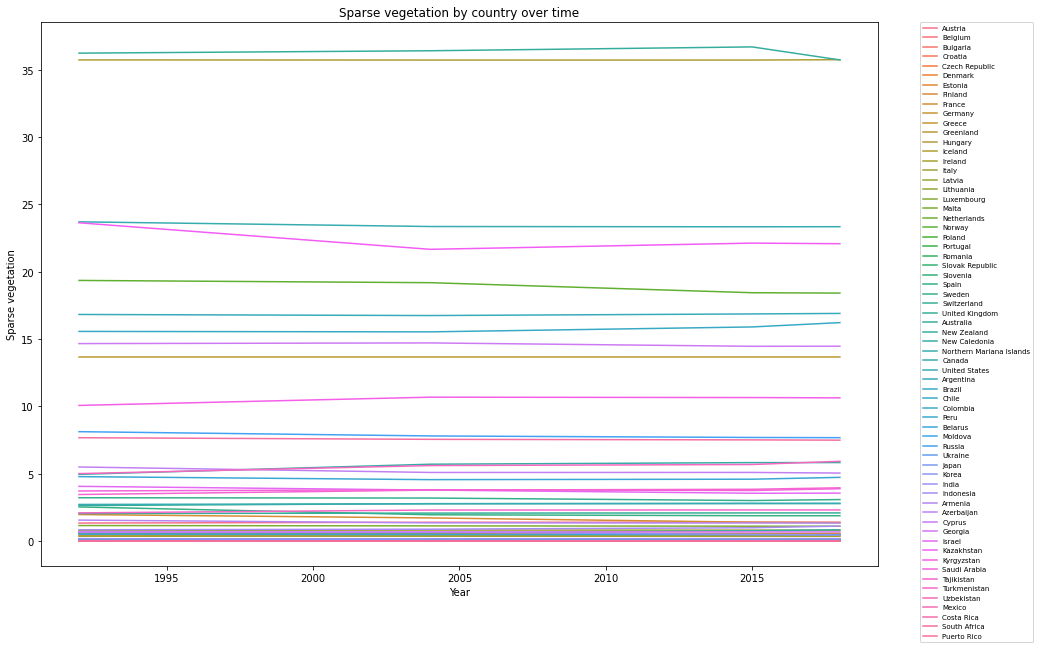

In [98]:
#plot the sparse vegetation over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Sparse vegetation by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Sparse vegetation',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

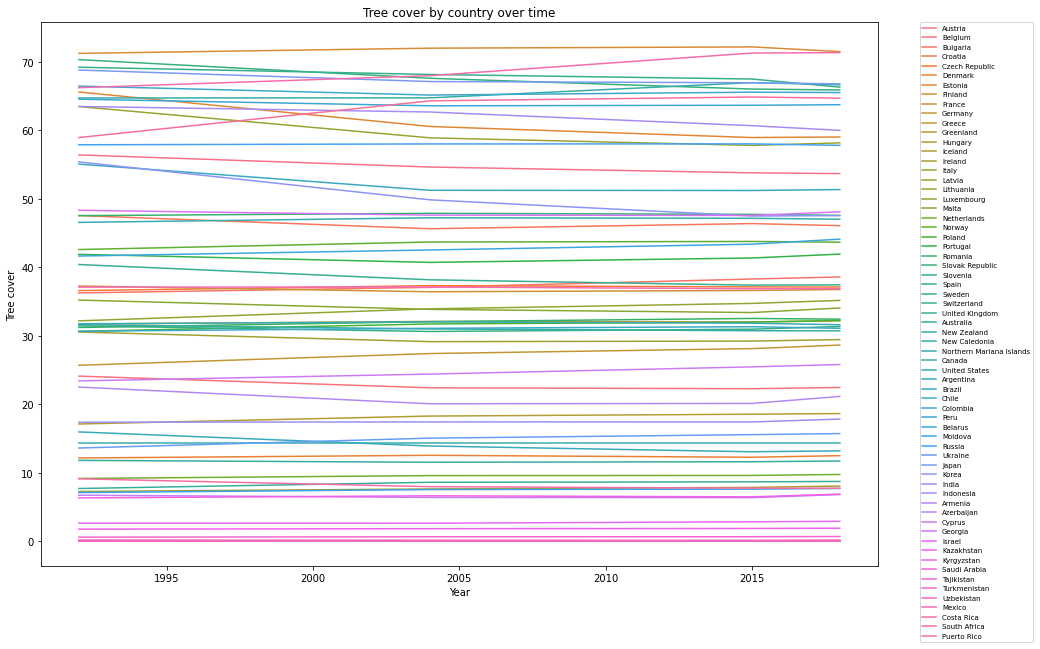

In [99]:
#plot the tree cover over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Tree cover by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Tree cover',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

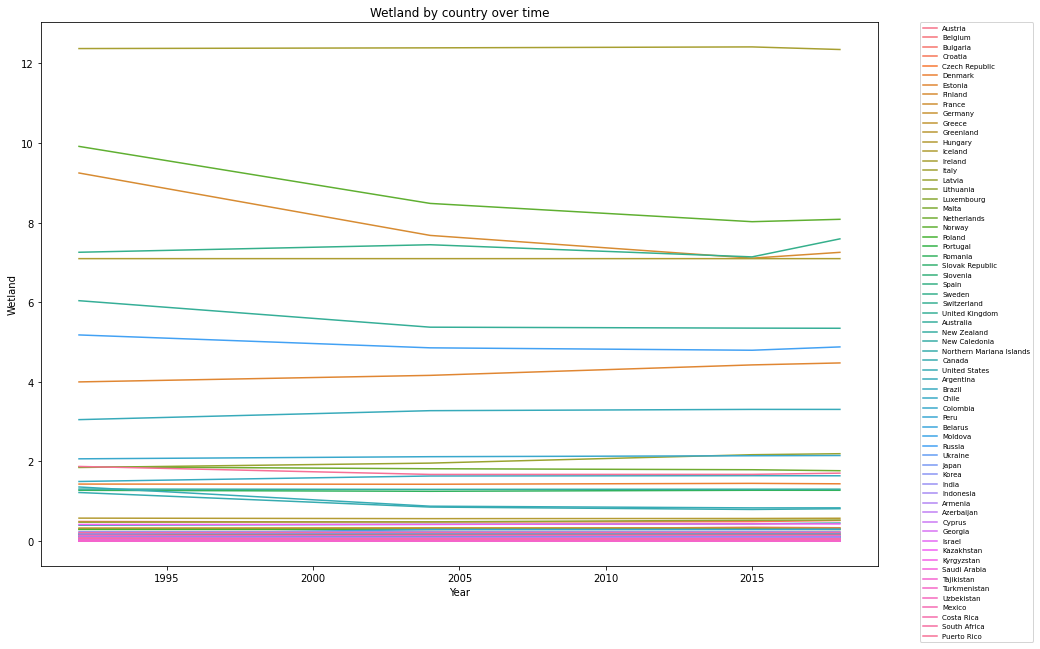

In [100]:
#plot the wetland over years by country
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Wetland by country over time')

sns.lineplot(
    data=land_cover_OECD.reset_index(),
    x='Year',
    y='Wetland',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

### Conclusions
For the artificial surfaces we can see a major change for our biggest timespan from 1992-2004 in some countries and for a few countries we can see a jump from 2004-2015. However for The shortest timespan from 2015-2018 we can hardly see any markable change across all variables. Excluding artificial surfaces, the data ist quite constant over the whole timespan, as we expected. Especially the ratio 2015/2018 suggests that one can use recent land cover data to approximate the data of the following years, as the properties don't significantly change over a short period of time. However a problem encountered is that for a few countries all entries of some values are 0 over all years. This can suggest that the data just isn't available for that country or that the % of given land cover is actually 0.

In [101]:
#extract our 2018 data
land_cover2018 =   land_cover_rel.iloc[land_cover_rel.index.get_level_values('Year') == 2018]
land_cover2018.shape

(236, 9)

In [102]:
#descriptive statistics
land_cover2018.describe()

Artificial surfaces   Bare area    Cropland   Grassland  Inland water  \
count           236.000000  236.000000  236.000000  236.000000    236.000000   
mean              3.274819   12.117159   27.178701    8.833833      5.794420   
std               9.807513   26.336930   22.388281   15.280070     13.562647   
min               0.000000    0.000000    0.000000    0.000000      0.000000   
25%               0.123466    0.000000    7.806774    0.096397      0.799938   
50%               0.569402    0.072513   23.364426    2.765517      1.674404   
75%               1.965186    4.094473   43.805507   10.689944      4.474193   
max             100.000000   99.871986   87.579618   88.624788    100.000000   

        Shrubland  Sparse vegetation  Tree cover     Wetland  
count  236.000000         236.000000  236.000000  236.000000  
mean     5.278640           3.060210   33.086850    1.375368  
std     10.848790           6.588589   28.104437    3.655866  
min      0.000000           0.000000    0.000000    0.000000  
25%      0.000000           0.008034    5.868930    0.001665  
50%      0.376116           0.139986   31.230774    0.118505  
75%      5.030730           3.081576   57.213742    0.700044  
max     76.679242          46.950629   97.392105   32.498908

## Data Exploration

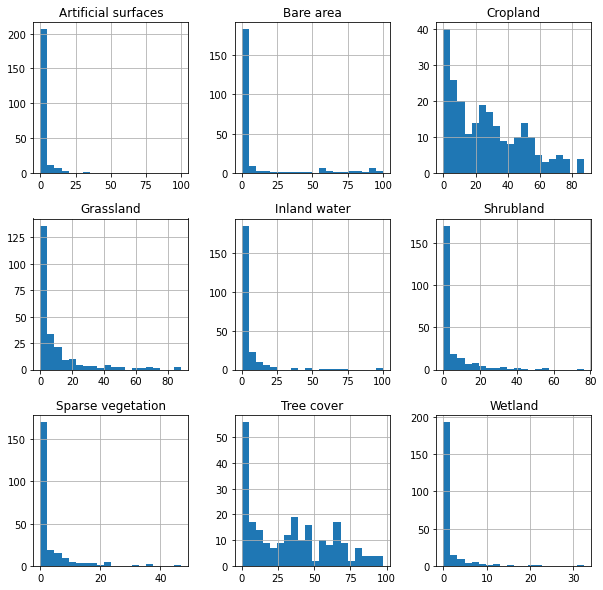

In [103]:
fig, axes = plt.subplots(len(land_cover2018.columns)//3, 3, figsize=(10, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        land_cover2018.hist(column = land_cover2018.columns[i], bins = 20, ax=axis)
        i = i+1

In [104]:
land_cover2018.index = land_cover2018.index.droplevel('Year')
land_cover2018.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country                                                                
Afghanistan                0.144171  39.153980  12.120421  37.161205   
Albania                    1.076736   1.682400  48.785857   5.348827   
Algeria                    0.123073  89.988986   4.599071   0.003802   
American Samoa             0.038506   0.000000  59.992299   0.000000   
Andorra                    0.877637   4.135021   1.012658  23.881857   

                Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                  
Afghanistan         0.099181   3.545002           6.528826    1.236130   
Albania             2.259645   3.053523           1.328761   36.185951   
Algeria             0.064360   0.715815           3.637610    0.866315   
American Samoa      4.736234   0.000000           0.077012   35.155949   
Andorra             0.000000   0.033755          10.464135   59.594937   

                 Wetland  
Country                   
Afghanistan     0.011085  
Albania         0.278300  
Algeria         0.000967  
American Samoa  0.000000  
Andorra         0.000000

To test if the many 0 values are reasonable, we add a column that sums up all the percentages for each country and check if they rouhgly sum up to 1.

In [105]:
land_cover_sum = land_cover2018.copy()
land_cover_sum['Total'] = land_cover_sum.sum(axis=1)
land_cover_sum.head()

Artificial surfaces  Bare area   Cropland  Grassland  \
Country                                                                
Afghanistan                0.144171  39.153980  12.120421  37.161205   
Albania                    1.076736   1.682400  48.785857   5.348827   
Algeria                    0.123073  89.988986   4.599071   0.003802   
American Samoa             0.038506   0.000000  59.992299   0.000000   
Andorra                    0.877637   4.135021   1.012658  23.881857   

                Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                  
Afghanistan         0.099181   3.545002           6.528826    1.236130   
Albania             2.259645   3.053523           1.328761   36.185951   
Algeria             0.064360   0.715815           3.637610    0.866315   
American Samoa      4.736234   0.000000           0.077012   35.155949   
Andorra             0.000000   0.033755          10.464135   59.594937   

                 Wetland  Total  
Country                          
Afghanistan     0.011085  100.0  
Albania         0.278300  100.0  
Algeria         0.000967  100.0  
American Samoa  0.000000  100.0  
Andorra         0.000000  100.0

In [106]:
land_cover_sum.describe()

Artificial surfaces   Bare area    Cropland   Grassland  Inland water  \
count           236.000000  236.000000  236.000000  236.000000    236.000000   
mean              3.274819   12.117159   27.178701    8.833833      5.794420   
std               9.807513   26.336930   22.388281   15.280070     13.562647   
min               0.000000    0.000000    0.000000    0.000000      0.000000   
25%               0.123466    0.000000    7.806774    0.096397      0.799938   
50%               0.569402    0.072513   23.364426    2.765517      1.674404   
75%               1.965186    4.094473   43.805507   10.689944      4.474193   
max             100.000000   99.871986   87.579618   88.624788    100.000000   

        Shrubland  Sparse vegetation  Tree cover     Wetland         Total  
count  236.000000         236.000000  236.000000  236.000000  2.360000e+02  
mean     5.278640           3.060210   33.086850    1.375368  1.000000e+02  
std     10.848790           6.588589   28.104437    3.655866  4.760214e-13  
min      0.000000           0.000000    0.000000    0.000000  1.000000e+02  
25%      0.000000           0.008034    5.868930    0.001665  1.000000e+02  
50%      0.376116           0.139986   31.230774    0.118505  1.000000e+02  
75%      5.030730           3.081576   57.213742    0.700044  1.000000e+02  
max     76.679242          46.950629   97.392105   32.498908  1.000000e+02

Our minimum and maximum value for the total column is 100, which means that the land coverage indeed sums up to 100%. But this is still no evidence that those types of land coverage are just not present in those cases. It could still be the case that this table is just derived from the absolute values and those have missing values.

This is why we inspect the absolute values in the next step and compare them to the total area of the countries and see if there are major differences

In [107]:
#for our analysis we use the relative data, to make it comparable across countries of different sizes
land_cover_abs = land_cover.copy()
land_cover_abs = land_cover_abs[land_cover_abs['MEAS'] == 'THOUSAND_SQKM']
land_cover_abs.shape

(8856, 21)

In [108]:
#getting the data in the same shape as our relative data
land_cover_abs = land_cover_abs[['Country', 'Year', 'Land cover class', 'Value']]
land_cover_abs = land_cover_abs.pivot_table(index=['Country','Year'],columns='Land cover class', values='Value')
land_cover_abs.columns.name = None
land_cover2018_abs =  land_cover_abs.iloc[land_cover_abs.index.get_level_values('Year') == 2018]
land_cover2018_abs.shape

(246, 9)

In [109]:
#sum up the land coverage
land_cover2018_abs_sum =  land_cover2018_abs.copy()
land_cover2018_abs_sum['Sum'] = land_cover2018_abs_sum.sum(axis=1)
land_cover2018_abs_sum.head()

Artificial surfaces    Bare area    Cropland   Grassland  \
Country        Year                                                             
Afghanistan    2018             0.927717   251.949704   77.993003  239.126511   
Albania        2018             0.310373     0.484957   14.062674    1.541816   
Algeria        2018             2.852011  2085.339874  106.575563    0.088104   
American Samoa 2018             0.000077     0.000000    0.120408    0.000000   
Andorra        2018             0.004019     0.018935    0.004637    0.109357   

                     Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country        Year                                                           
Afghanistan    2018      0.638211  22.811532          42.011969    7.954301   
Albania        2018      0.651350   0.880187           0.383020   10.430712   
Algeria        2018      1.491427  16.587774          84.295359   20.075369   
American Samoa 2018      0.009506   0.000000           0.000155    0.070560   
Andorra        2018      0.000000   0.000155           0.047916    0.272890   

                      Wetland          Sum  
Country        Year                         
Afghanistan    2018  0.071333   643.484282  
Albania        2018  0.080221    28.825309  
Algeria        2018  0.022412  2317.327894  
American Samoa 2018  0.000000     0.200707  
Andorra        2018  0.000000     0.457908

In [110]:
#prepare for merging
land_cover_abs_mer = land_cover2018_abs_sum.copy()
land_cover_abs_mer = land_cover_abs_mer.reset_index()
land_cover_abs_mer = land_cover_abs_mer[['Country','Sum']]

In [111]:
#getting data for total country area and only keep the country name and the value for 2018 (and dividing them by 1000, 
#as this is the unit used for our data)
TOTAL_AREA = pd.read_csv(TOTAL_AREA)
total_area = TOTAL_AREA.copy()
total_area = total_area[['Country Name','2018']]
total_area = total_area.rename(columns={'Country Name': 'Country', '2018': 'Total'})
total_area['Total']=total_area['Total']/1000
total_area.head()

Country    Total
0        Aruba     0.18
1  Afghanistan   652.86
2       Angola  1246.70
3      Albania    28.75
4      Andorra     0.47

In [112]:
#merge country area data with land cover data, compute differences and show descriptive statistics (we reduce the inspected
#countries to the OECD countries again, as those are (almost all) relevant for our analysis and it gives a better overview)
area_merged = land_cover_abs_mer.merge(total_area, on='Country', how='inner')
area_merged['Difference'] = area_merged['Total']-area_merged['Sum']
#difference relative to the total area
area_merged['Relative_Difference'] = abs(area_merged['Difference'])/area_merged['Total']
area_merged_OECD = area_merged[area_merged['Country'].isin(SELECTED_COUNTRIES)]
area_merged_OECD.describe()

Sum        Total   Difference  Relative_Difference
count    62.000000    62.000000    62.000000            62.000000
mean   1038.169504  1027.662742   -10.506762             0.107145
std    2212.262495  2252.495884   240.247610             0.550100
min       0.314778     0.320000 -1742.914324             0.000160
25%      49.575097    49.547500    -0.455296             0.001853
50%     185.968682   174.490000     0.036203             0.004185
75%     628.771630   589.934248     0.610940             0.012500
max    9807.449189  9984.670000   435.199635             4.246350

We can see a huge outlier with our max value, where the total area is 4 times bigger than our OECD sum. This is the case for greendland, which is not present in our final data. We remove this entry and compute our stats again.

In [113]:
index = area_merged_OECD[area_merged_OECD['Country'] == 'Greenland'].index
area_merged_OECD.drop(index , inplace=True)
area_merged_OECD.describe()

Sum        Total  Difference  Relative_Difference
count    61.000000    61.000000   61.000000            61.000000
mean   1019.887622  1037.780984   17.893362             0.039289
std    2225.894497  2269.767989   88.545393             0.131991
min       0.314778     0.320000 -114.266445             0.000160
25%      48.978658    49.030000   -0.415003             0.001798
50%     164.954119   141.380000    0.051342             0.004162
75%     599.871684   603.550000    0.616755             0.012137
max    9807.449189  9984.670000  435.199635             0.904782

### Conclusion
The difference between the sum of land cover data and the total land area from the worldbank data has a mean of 3% (after removing our outlier) for our sample of countries. This leads to solid evidence for the assumption that those 0 values are natural and can be seen as valid features for our future model. The fact that there is a difference will most likely be based on different sources and different measurement criteria for the total area, as well as inaccuracies. 

Returning to our relevant data: As we have percentages for every value, we calculate the corresponding decimal value for the future work, which is also a benefit, because we then naturally have our values in a range from 0-1.

In [114]:
land_cover2018 = land_cover2018/100
land_cover2018

Artificial surfaces  Bare area  Cropland  Grassland  \
Country                                                                  
Afghanistan                   0.001442   0.391540  0.121204   0.371612   
Albania                       0.010767   0.016824  0.487859   0.053488   
Algeria                       0.001231   0.899890  0.045991   0.000038   
American Samoa                0.000385   0.000000  0.599923   0.000000   
Andorra                       0.008776   0.041350  0.010127   0.238819   
...                                ...        ...       ...        ...   
Wallis and Futuna             0.003272   0.000000  0.524537   0.000000   
Western Sahara                0.000089   0.998720  0.000267   0.000000   
Yemen                         0.000927   0.788603  0.047031   0.000966   
Zambia                        0.001160   0.000057  0.168463   0.015544   
Zimbabwe                      0.001771   0.002299  0.369198   0.037601   

                   Inland water  Shrubland  Sparse vegetation  Tree cover  \
Country                                                                     
Afghanistan            0.000992   0.035450           0.065288    0.012361   
Albania                0.022596   0.030535           0.013288    0.361860   
Algeria                0.000644   0.007158           0.036376    0.008663   
American Samoa         0.047362   0.000000           0.000770    0.351559   
Andorra                0.000000   0.000338           0.104641    0.595949   
...                         ...        ...                ...         ...   
Wallis and Futuna      0.227917   0.000000           0.000000    0.244275   
Western Sahara         0.000183   0.000000           0.000741    0.000000   
Yemen                  0.002263   0.034993           0.114995    0.010203   
Zambia                 0.018611   0.136371           0.000000    0.622014   
Zimbabwe               0.011432   0.270810           0.000460    0.305763   

                    Wetland  
Country                      
Afghanistan        0.000111  
Albania            0.002783  
Algeria            0.000010  
American Samoa     0.000000  
Andorra            0.000000  
...                     ...  
Wallis and Futuna  0.000000  
Western Sahara     0.000000  
Yemen              0.000019  
Zambia             0.037779  
Zimbabwe           0.000668  

[236 rows x 9 columns]

In [115]:
ds_land_cover = land_cover2018.reset_index(drop=False).copy()

## Protected Areas by Management Objective

This data set was obtained from the OECD repository and answers the questions: how extensive are protected areas and what management objectives are pursued via protected area designation?
The numbers are provided in square km but also as relative numbers.
We only use relative numbers of terrestrial areas for our analysis.

Because overlaps among protected areas are relatively common, the total protected area for a country is typically less than the sum of the disaggregated areas.

We have to note that not all protected areas have a designation date recorded.
When there is no designation date the protected area is deemed to have always existed, therefore historical data maybe be overestimated.

The data was last updated in June 2020 and is therefore reasonable up-to-date.

### Load Protected Areas Data

First, we load the raw CSV file.

In [116]:
# load data
def load_protected_area():
    PROTECTED_AREAS = DATA_PATH / 'OECD' / 'PROTECTED_AREAS_OBJECTIVE.csv'
    data = pd.read_csv(PROTECTED_AREAS)
    return data
protected_area_raw = load_protected_area()
protected_area_raw.shape

(71910, 23)

### Clean Protected Area Data

The data contains a lot of redundant and useless information. Thus, we only select a subset of needed columns.
Further, only units with "Percentage" are selected. These percentages need to be transformed to relative numbers to be consistent over all data sets.
Some countries have relative protected areas above 100%.
The metadata tells us that this is due to the fact that some countries have some protected areas recorded as points with a reported area. This point data is more uncertain than protected areas reported as polygons because overlaps cannot be identified or resolved.
Because only 4 countries are effected by this and all of them are small islands we assume a total protected area of 100% for them.

In [117]:
# unique values per column
protected_area_raw.nunique()

COU                        127
Country                    127
DESIG                        9
Designation                  9
DOMAIN                       2
Domain                       2
MEASURE                      2
Measure                      2
CALCULATION                  1
Calculation method           1
SCOPE                        1
Scope                        1
YEA                         17
Year                        17
Unit Code                    2
Unit                         2
PowerCode Code               1
PowerCode                    1
Reference Period Code        0
Reference Period             0
Value                    10090
Flag Codes                   0
Flags                        0
dtype: int64

In [118]:
# countries with more than 100 % protected area
protected_area_lt_100 = protected_area_raw[protected_area_raw['Unit'] == 'Percentage']
protected_area_lt_100 = protected_area_lt_100[protected_area_lt_100['Value'] > 100]
protected_area_lt_100['Country'].unique()

array(['New Caledonia', 'Saint Helena', 'Bouvet Island',
       'British Indian Ocean Territory'], dtype=object)

In [119]:
def clean_protected_area(raw_data):
    # filter only Terrestrial protected area
    data = raw_data[raw_data['Domain'] == 'Terrestrial']

    # filter only percentages 
    data = data[data['Unit'] == 'Percentage']

    # select subset of columns needed
    data = data[['Country', 'Year', 'Designation', 'Value']]

    # calculate percentages
    data['Value'] = data['Value'] / 100
    # assume 100% protected area for small islands
    data['Value'] = data['Value'].apply(lambda x: 1 if x > 1 else x) 

    return data
protected_area_cleaned = clean_protected_area(protected_area_raw)
protected_area_cleaned.shape

(18972, 4)

In [120]:
protected_area_cleaned.head()

Country  Year                Designation   Value
17  Australia  1970  Ia: Strict Nature Reserve  0.0045
18  Australia  1980  Ia: Strict Nature Reserve  0.0135
19  Australia  1990  Ia: Strict Nature Reserve  0.0166
20  Australia  1995  Ia: Strict Nature Reserve  0.0174
21  Australia  2000  Ia: Strict Nature Reserve  0.0177

In [121]:
protected_area_cleaned.describe()

Year         Value
count  18972.000000  18972.000000
mean    2006.176471      0.039366
std       14.114342      0.118906
min     1970.000000      0.000000
25%     2000.000000      0.000000
50%     2012.000000      0.000500
75%     2016.000000      0.019300
max     2020.000000      1.000000

The data includes information from 1970 up to 2020.
For most of the protected areas by management objective we observe a rather small percentage with a mean of 4%.
But we have to take into account that there are 8 categories.

## Feature preparation

As we want to know the relative numbers by management objective we transform the data to have one column by management objective.
We also rename the objectives to make them more consistent with other column naming.
Further, the data is filtered for selected countries and for the year 2020.

In [122]:
protected_area_cleaned['Designation'].unique()

array(['Ia: Strict Nature Reserve', 'Ib: Wilderness Area',
       'II: National Park', 'III: Natural Monument or Feature',
       'IV: Habitat or Species Management Area',
       'V: Protected Landscape or Seascape',
       'VI: Protected area with sustainable use of natural resources',
       'No IUCN category provided',
       'All, including data recorded as points'], dtype=object)

In [123]:
# check for missing values
protected_area_cleaned.isna().sum()

Country        0
Year           0
Designation    0
Value          0
dtype: int64

In [124]:
def transform_protected_area(cleaned_data, filter_year=None, filter_countries=None):

    # create DataFrame with all vealues per country and year
    data = cleaned_data.pivot_table(index=['Country', 'Year'], columns='Designation', values='Value')
    data.columns.name = None
    data = data.reset_index()

    # rename columns by management objective
    data = data.rename(columns={
        'Ia: Strict Nature Reserve': 'perc_area_protected_obj_1a',
        'Ib: Wilderness Area': 'perc_area_protected_obj_1b',
        'II: National Park': 'perc_area_protected_obj_2',
        'III: Natural Monument or Feature': 'perc_area_protected_obj_3',
        'IV: Habitat or Species Management Area': 'perc_area_protected_obj_4',
        'V: Protected Landscape or Seascape': 'perc_area_protected_obj_5',
        'VI: Protected area with sustainable use of natural resources': 'perc_area_protected_obj_6',
        'No IUCN category provided': 'perc_area_protected_no_obj',
        'All, including data recorded as points': 'perc_area_protected_all_obj'
    })

    if filter_year is not None:
        data = data[data['Year'] == filter_year]

    if filter_countries is not None:
       data = data[data['Country'].isin(filter_countries)]
    return data

# load all data for selected countries and all years
protected_area_all_years = transform_protected_area(
    protected_area_cleaned,
    filter_countries=SELECTED_COUNTRIES)
assert len(SELECTED_COUNTRIES) == protected_area_all_years['Country'].unique().shape[0]
protected_area_all_years.shape

(1105, 11)

In [125]:
protected_area_all_years.head()

Country  Year  perc_area_protected_all_obj  perc_area_protected_obj_2  \
68  Argentina  1970                       0.0104                     0.0066   
69  Argentina  1980                       0.0249                     0.0110   
70  Argentina  1990                       0.0430                     0.0122   
71  Argentina  1995                       0.0521                     0.0136   
72  Argentina  2000                       0.0636                     0.0152   

    perc_area_protected_obj_3  perc_area_protected_obj_4  \
68                     0.0001                     0.0000   
69                     0.0001                     0.0015   
70                     0.0001                     0.0015   
71                     0.0003                     0.0017   
72                     0.0004                     0.0018   

    perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
68                      0.0001                         0.0   
69                      0.0001                         0.0   
70                      0.0025                         0.0   
71                      0.0026                         0.0   
72                      0.0027                         0.0   

    perc_area_protected_no_obj  perc_area_protected_obj_5  \
68                      0.0004                     0.0000   
69                      0.0004                     0.0000   
70                      0.0007                     0.0000   
71                      0.0008                     0.0009   
72                      0.0046                     0.0030   

    perc_area_protected_obj_6  
68                     0.0029  
69                     0.0115  
70                     0.0251  
71                     0.0312  
72                     0.0349

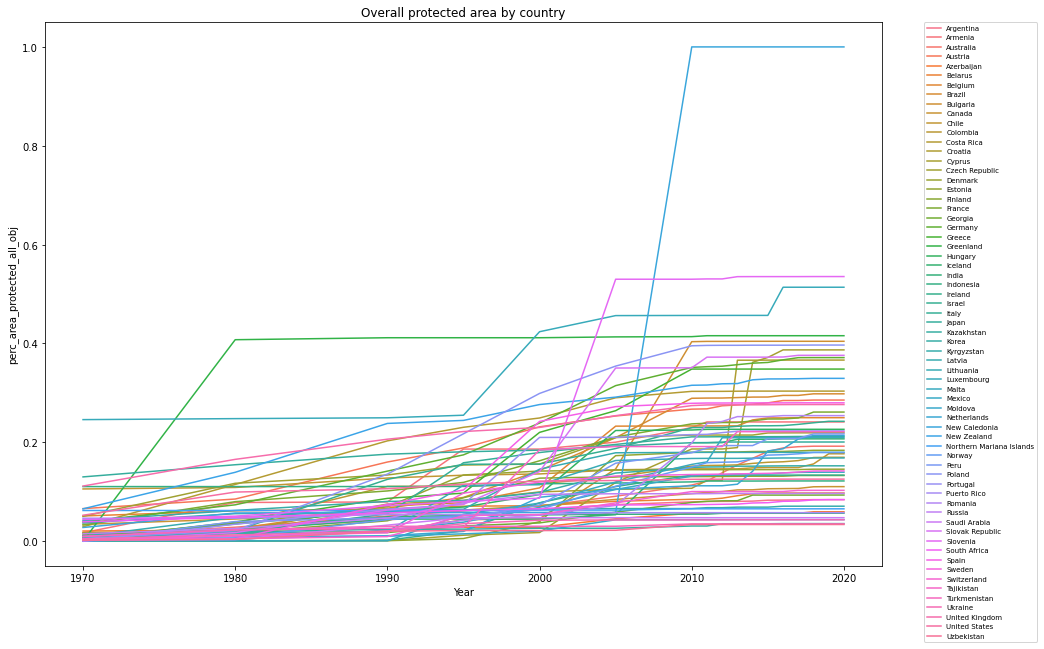

In [126]:
# plot changes over years in overall protected area
f, ax = plt.subplots(figsize=(15, 10))
ax.set_title('Overall protected area by country')

sns.lineplot(
    data=protected_area_all_years,
    x='Year',
    y='perc_area_protected_all_obj',
    hue="Country")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=7)
plt.show()

As we in the above figure most of the countries have a total protected area under 20% and almost all them under 40%.
The major increases in protected area happened in the 1990 and early 2000.
In the last years almost no country increased their protected areas. Thus, we decided against computing features that help predicting the trend but only use the most recent year for our analysis.

In [127]:
# load all data for selected countries and all year 2020
ds_protected_areas = transform_protected_area(
    protected_area_cleaned,
    filter_year=2020,
    filter_countries=SELECTED_COUNTRIES)

# Dataset Merging
Merge IUCN Data with different Support Datasets. Use Country as keys.
## Constants

In [130]:
RANDOM_STATE = 42

## IUCN Data
### Load IUCN

In [134]:
iucn_data = IUCN_cleaned_data.copy()

## Country Characteristics Data
### Load and Merge

In [135]:
coun_list = []
country_sets = []

for ds in [ds_protected_areas, ds_land_cover, ds_climate, ds_ghg]:
    coun_list.append(ds)
    country_sets.append(set(ds['Country']))

In [136]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2], country_sets[3])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 42 intersecting countries, which are: {'Iceland', 'Israel', 'Hungary', 'Slovenia', 'Argentina', 'Austria', 'Slovak Republic', 'Australia', 'Colombia', 'Korea', 'France', 'Czech Republic', 'Greece', 'Latvia', 'Russia', 'United States', 'India', 'Spain', 'Italy', 'Portugal', 'Ireland', 'Lithuania', 'Norway', 'Switzerland', 'Brazil', 'Belgium', 'Finland', 'Luxembourg', 'United Kingdom', 'Sweden', 'Chile', 'Canada', 'Estonia', 'Germany', 'Costa Rica', 'Denmark', 'Mexico', 'New Zealand', 'Indonesia', 'Netherlands', 'Japan', 'Poland'}


--> Join Datasets on those countries.

In [137]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

Country  Year  perc_area_protected_all_obj  perc_area_protected_obj_2  \
0  Argentina  2020                       0.0839                     0.0184   
1  Australia  2020                       0.1920                     0.0417   
2    Austria  2020                       0.2854                     0.0238   
3    Belgium  2020                       0.2497                     0.0007   
4     Brazil  2020                       0.2980                     0.0413   

   perc_area_protected_obj_3  perc_area_protected_obj_4  \
0                     0.0004                     0.0019   
1                     0.0024                     0.0027   
2                     0.0001                     0.0580   
3                     0.0000                     0.0154   
4                     0.0007                     0.0003   

   perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
0                      0.0027                      0.0003   
1                      0.0201                      0.0057   
2                      0.0001                      0.0012   
3                      0.0000                      0.0000   
4                      0.0206                      0.0000   

   perc_area_protected_no_obj  perc_area_protected_obj_5  ...  temp_slope  \
0                      0.0146                     0.0033  ...    0.014949   
1                      0.0034                     0.0098  ...    0.017804   
2                      0.0462                     0.1535  ...    0.038525   
3                      0.0919                     0.1259  ...    0.028670   
4                      0.1183                     0.0458  ...    0.033281   

   gain_percentage  temp_difference           CH4           CO2           HFC  \
0         0.500525         0.072246  4.286108e-08  1.103889e-07  3.367829e-10   
1         0.969423         0.214683  1.753517e-07  6.659066e-07  1.918229e-08   
2        24.241043         1.498389  8.243552e-08  8.542299e-07  2.349091e-08   
3        12.044550         1.167659  6.035386e-08  7.705611e-07  3.437139e-08   
4         3.703937         0.929317  8.487416e-09  1.294178e-08 -1.000000e+00   

            N2O           NF3           PFC           SF6  
0  2.348549e-08 -1.000000e+00  8.774988e-11  9.760056e-13  
1  3.220150e-08 -1.000000e+00  3.778206e-10  3.658618e-10  
2  4.514538e-08  2.114075e-10  4.163494e-10  4.892820e-09  
3  4.384847e-08  4.967500e-12  1.009810e-09  7.310992e-10  
4  4.508145e-09 -1.000000e+00 -1.000000e+00 -1.000000e+00  

[5 rows x 30 columns]

### Analysis
#### General Information

In [138]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      42 non-null     object 
 1   Year                         42 non-null     int64  
 2   perc_area_protected_all_obj  42 non-null     float64
 3   perc_area_protected_obj_2    42 non-null     float64
 4   perc_area_protected_obj_3    42 non-null     float64
 5   perc_area_protected_obj_4    42 non-null     float64
 6   perc_area_protected_obj_1a   42 non-null     float64
 7   perc_area_protected_obj_1b   42 non-null     float64
 8   perc_area_protected_no_obj   42 non-null     float64
 9   perc_area_protected_obj_5    42 non-null     float64
 10  perc_area_protected_obj_6    42 non-null     float64
 11  Artificial surfaces          42 non-null     float64
 12  Bare area                    42 non-null     float64
 13  Cropland              

There are no missing values in the dataset.

In [139]:
coun_data.describe()

Year  perc_area_protected_all_obj  perc_area_protected_obj_2  \
count    42.0                    42.000000                  42.000000   
mean   2020.0                     0.222829                   0.041517   
std       0.0                     0.107664                   0.059849   
min    2020.0                     0.056400                   0.000000   
25%    2020.0                     0.142875                   0.006525   
50%    2020.0                     0.203700                   0.020250   
75%    2020.0                     0.278925                   0.048125   
max    2020.0                     0.535300                   0.326100   

       perc_area_protected_obj_3  perc_area_protected_obj_4  \
count                  42.000000                  42.000000   
mean                    0.003624                   0.029648   
std                     0.019175                   0.034700   
min                     0.000000                   0.000100   
25%                     0.000000                   0.004400   
50%                     0.000200                   0.015550   
75%                     0.000700                   0.038775   
max                     0.124700                   0.147400   

       perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
count                   42.000000                   42.000000   
mean                     0.004457                    0.008726   
std                      0.006766                    0.018277   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000700                    0.000050   
75%                      0.005450                    0.005250   
max                      0.021800                    0.075300   

       perc_area_protected_no_obj  perc_area_protected_obj_5  \
count                   42.000000                  42.000000   
mean                     0.069005                   0.047824   
std                      0.087672                   0.059991   
min                      0.000000                   0.000000   
25%                      0.004725                   0.001100   
50%                      0.033750                   0.014300   
75%                      0.112900                   0.077800   
max                      0.403000                   0.252400   

       perc_area_protected_obj_6  ...  temp_slope  gain_percentage  \
count                  42.000000  ...   42.000000        42.000000   
mean                    0.015333  ...    0.032865        10.864795   
std                     0.027411  ...    0.013226        12.305045   
min                     0.000000  ...    0.006156       -24.178355   
25%                     0.000000  ...    0.021700         3.832235   
50%                     0.000850  ...    0.034182         9.547614   
75%                     0.015525  ...    0.038667        17.897105   
max                     0.106300  ...    0.058883        43.855657   

       temp_difference           CH4           CO2           HFC  \
count        42.000000  4.200000e+01  4.200000e+01  4.200000e+01   
mean          0.987359  3.038401e-07  2.161836e-06 -4.761899e-02   
std           0.448411  8.256327e-07  6.019404e-06  2.155403e-01   
min           0.072246  2.719479e-10  1.038968e-09 -1.000000e+00   
25%           0.659961  1.400321e-08  9.897744e-08  2.855636e-09   
50%           0.943211  6.667557e-08  4.979392e-07  1.584147e-08   
75%           1.382112  1.701783e-07  1.182617e-06  3.763667e-08   
max           1.852533  5.063948e-06  2.953497e-05  1.344122e-06   

                N2O           NF3           PFC           SF6  
count  4.200000e+01  4.200000e+01  4.200000e+01  4.200000e+01  
mean   1.569980e-07 -6.666667e-01 -1.666667e-01 -4.761905e-02  
std    4.037571e-07  4.771187e-01  3.771955e-01  2.155403e-01  
min    7.547297e-11 -1.000000e+00 -1.000000e+00 -1.000000e+00  
25%    6.067052e-09 -1.000000e+00  2.075188e-12  8.52198

In [140]:
coun_data['Country'].nunique()

42

## Full Data
### Merge both datasets
#### Check Keys (countries)

In [142]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'Saudi Arabia', 'Bulgaria', 'Belarus', 'Puerto Rico', 'Kyrgyzstan', 'Peru', 'Kazakhstan', 'Croatia', 'Greenland', 'South Africa', 'Armenia', 'Moldova', 'Azerbaijan', 'Cyprus', 'Northern Mariana Islands', 'Uzbekistan', 'Romania', 'Turkmenistan', 'Malta', 'Ukraine', 'New Caledonia', 'Georgia', 'Tajikistan'}
CHAR \ IUCN: set()


In [143]:
oecd_list = [
    'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'CANADA', 'CHILE', 'COLOMBIA',
    'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GERMANY',
    'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY', 'JAPAN',
    'KOREA', 'LATVIA', 'LITHUANIA', 'LUXEMBOURG', 'MEXICO', 'NETHERLANDS',
    'NEW ZEALAND', 'NORWAY', 'POLAND', 'PORTUGAL', 'SLOVAK REPUBLIC',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'TURKEY', 'UNITED KINGDOM',
    'UNITED STATES'
]
oecd_list = [c.title() for c in oecd_list]
len(oecd_list)

37

In [144]:
set(oecd_list).difference(iucn_countries)

{'Turkey'}

In [145]:
set(oecd_list).difference(char_countries)

{'Turkey'}

In [146]:
iucn_diff_list = [c for c in iucn_countries.difference(char_countries)]
set(iucn_diff_list).intersection(set(oecd_list))

set()

#### Rename Country Data to Match IUCN Data

In [147]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

#### Merge 

In [148]:
iucn_data = iucn_data.rename(columns={'country':'Country'})
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

36

In [149]:
full_data.columns.values

array(['group', 'scientific_name', 'trend', 'threat_level', 'Country',
       'Year', 'perc_area_protected_all_obj', 'perc_area_protected_obj_2',
       'perc_area_protected_obj_3', 'perc_area_protected_obj_4',
       'perc_area_protected_obj_1a', 'perc_area_protected_obj_1b',
       'perc_area_protected_no_obj', 'perc_area_protected_obj_5',
       'perc_area_protected_obj_6', 'Artificial surfaces', 'Bare area',
       'Cropland', 'Grassland', 'Inland water', 'Shrubland',
       'Sparse vegetation', 'Tree cover', 'Wetland', 'temp_slope',
       'gain_percentage', 'temp_difference', 'CH4', 'CO2', 'HFC', 'N2O',
       'NF3', 'PFC', 'SF6'], dtype=object)

#### Merge with the relative number of threatened species
For the prediction of the number of species per country relative to the number of total described species, we merge our coun_data with the relative number of threatened species per country. After those steps we have got 36 countries left, with 29 different characteristics for each one. We also have the relative number of threatened species by the taxonomic group for the major land living groups. Those are mammals, insects, amphibians, birds and reptiles.

In [150]:
threatened_relative = ds_threatened_by_group.copy()
threatened_relative = threatened_relative.rename(columns={'country': 'Country'})

In [151]:
threatened_relative

Country  total_threatened  mammals_threatened  insects_threatened  \
0        Argentina            0.0791              0.1003              0.0744   
1          Armenia            0.0682              0.0761              0.0959   
2        Australia            0.1120              0.1864              0.1403   
3          Austria            0.0628              0.0568              0.0867   
4       Azerbaijan            0.0648              0.0577              0.0685   
..             ...               ...                 ...                 ...   
60    Turkmenistan            0.0686              0.0947              0.0923   
61         Ukraine            0.0846              0.1150              0.1189   
62  United Kingdom            0.0509              0.0533              0.0737   
63   United States            0.1292              0.0948              0.1540   
64      Uzbekistan            0.0704              0.1111              0.0351   

    amphibians_threatened  birds_threatened  reptiles_threatened  \
0                  0.2061            0.0519               0.0771   
1                  0.0000            0.0471               0.1628   
2                  0.2108            0.0716               0.0766   
3                  0.0000            0.0426               0.0769   
4                  0.0909            0.0489               0.1800   
..                    ...               ...                  ...   
60                 0.0000            0.0519               0.1111   
61                 0.0000            0.0535               0.0625   
62                 0.0000            0.0412               0.1429   
63                 0.2044            0.1044               0.1231   
64                 0.0000            0.0538               0.1842   

    mammals_resident  insects_resident  amphibians_resident  birds_resident  \
0               True              True                 True            True   
1               True              True                 True            True   
2               True              True                 True            True   
3               True              True                 True            True   
4               True              True                 True            True   
..               ...               ...                  ...             ...   
60              True              True                 True            True   
61              True              True                 True            True   
62              True              True                 True            True   
63              True              True                 True            True   
64              True              True                 True            True   

    reptiles_resident  
0                True  
1                True  
2                True  
3                True  
4                True  
..                ...  
60               True  
61               True  
62               True  
63               True  
64               True  

[65 rows x 12 columns]

In [152]:
threatened_countries = set(threatened_relative['Country'].unique())
print('THREAT \ CHAR: {}'.format(threatened_countries.difference(char_countries)))
print('CHAR \ THREAT: {}'.format(char_countries.difference(threatened_countries)))

THREAT \ CHAR: {'Saudi Arabia', 'Belarus', 'Bulgaria', 'Puerto Rico', 'Kyrgyzstan', 'Peru', 'Kazakhstan', 'Croatia', 'Greenland', 'South Africa', 'Armenia', 'Moldova', 'Azerbaijan', 'Cyprus', 'Northern Mariana Islands', 'Uzbekistan', 'Romania', 'Turkmenistan', 'Malta', 'Ukraine', 'New Caledonia', 'Georgia', 'Tajikistan'}
CHAR \ THREAT: set()


In [153]:
full_threatened = threatened_relative.merge(coun_data, on='Country', how='inner')
full_threatened.head()

Country  total_threatened  mammals_threatened  insects_threatened  \
0  Argentina            0.0791              0.1003              0.0744   
1  Australia            0.1120              0.1864              0.1403   
2    Austria            0.0628              0.0568              0.0867   
3    Belgium            0.0378              0.0417              0.0544   
4     Brazil            0.0861              0.1360              0.0807   

   amphibians_threatened  birds_threatened  reptiles_threatened  \
0                 0.2061            0.0519               0.0771   
1                 0.2108            0.0716               0.0766   
2                 0.0000            0.0426               0.0769   
3                 0.0000            0.0303               0.0000   
4                 0.0430            0.0914               0.0766   

   mammals_resident  insects_resident  amphibians_resident  ...  temp_slope  \
0              True              True                 True  ...    0.014949   
1              True              True                 True  ...    0.017804   
2              True              True                 True  ...    0.038525   
3              True              True                 True  ...    0.028670   
4              True              True                 True  ...    0.033281   

   gain_percentage  temp_difference           CH4           CO2           HFC  \
0         0.500525         0.072246  4.286108e-08  1.103889e-07  3.367829e-10   
1         0.969423         0.214683  1.753517e-07  6.659066e-07  1.918229e-08   
2        24.241043         1.498389  8.243552e-08  8.542299e-07  2.349091e-08   
3        12.044550         1.167659  6.035386e-08  7.705611e-07  3.437139e-08   
4         3.703937         0.929317  8.487416e-09  1.294178e-08 -1.000000e+00   

            N2O           NF3           PFC           SF6  
0  2.348549e-08 -1.000000e+00  8.774988e-11  9.760056e-13  
1  3.220150e-08 -1.000000e+00  3.778206e-10  3.658618e-10  
2  4.514538e-08  2.114075e-10  4.163494e-10  4.892820e-09  
3  4.384847e-08  4.967500e-12  1.009810e-09  7.310992e-10  
4  4.508145e-09 -1.000000e+00 -1.000000e+00 -1.000000e+00  

[5 rows x 41 columns]

In [154]:
#descriptive satistics for our final data frame
full_threatened.describe()

total_threatened  mammals_threatened  insects_threatened  \
count         36.000000           36.000000           36.000000   
mean           0.084056            0.101114            0.087264   
std            0.043261            0.070868            0.051773   
min            0.016700            0.000000            0.000000   
25%            0.047375            0.050100            0.060475   
50%            0.071400            0.089700            0.083700   
75%            0.121650            0.138025            0.100175   
max            0.166500            0.294000            0.234400   

       amphibians_threatened  birds_threatened  reptiles_threatened    Year  \
count              36.000000         36.000000            36.000000    36.0   
mean                0.114533          0.051697             0.095097  2020.0   
std                 0.156417          0.021114             0.111864     0.0   
min                 0.000000          0.016000             0.000000  2020.0   
25%                 0.000000          0.037575             0.000000  2020.0   
50%                 0.032150          0.044300             0.076750  2020.0   
75%                 0.207275          0.062050             0.153800  2020.0   
max                 0.563000          0.111900             0.500000  2020.0   

       perc_area_protected_all_obj  perc_area_protected_obj_2  \
count                    36.000000                  36.000000   
mean                      0.218903                   0.042853   
std                       0.109881                   0.063160   
min                       0.056400                   0.000000   
25%                       0.141350                   0.006425   
50%                       0.196250                   0.020250   
75%                       0.265775                   0.049350   
max                       0.535300                   0.326100   

       perc_area_protected_obj_3  ...  temp_slope  gain_percentage  \
count                  36.000000  ...   36.000000        36.000000   
mean                    0.000589  ...    0.032756        10.010823   
std                     0.001175  ...    0.012915        12.942997   
min                     0.000000  ...    0.006156       -24.178355   
25%                     0.000000  ...    0.022128         3.639039   
50%                     0.000150  ...    0.034182         8.858960   
75%                     0.000500  ...    0.038572        15.000800   
max                     0.005900  ...    0.058883        43.855657   

       temp_difference           CH4           CO2           HFC  \
count        36.000000  3.600000e+01  3.600000e+01  3.600000e+01   
mean          0.938828  3.064104e-07  2.411214e-06 -5.555549e-02   
std           0.446922  8.676097e-07  6.476293e-06  2.323107e-01   
min           0.072246  2.719479e-10  1.038968e-09 -1.000000e+00   
25%           0.603596  1.877395e-08  1.062423e-07  2.642616e-09   
50%           0.903967  6.667557e-08  4.979392e-07  1.584147e-08   
75%           1.220734  1.715439e-07  1.187701e-06  4.070487e-08   
max           1.852533  5.063948e-06  2.953497e-05  1.344122e-06   

                N2O           NF3           PFC           SF6  
count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  
mean   1.704893e-07 -6.944444e-01 -1.944444e-01 -5.555555e-02  
std    4.330457e-07  4.671766e-01  4.013865e-01  2.323107e-01  
min    7.547297e-11 -1.000000e+00 -1.000000e+00 -1.000000e+00  
25%    8.856383e-09 -1.000000e+00  9.493085e-15  8.050313e-11  
50%    3.130892e-08 -1.000000e+00  1.091419e-10  3.912131e-10  
75%    1.016315e-07  4.927475e-13  5.060522e-10  1.532690e-09  
max    2.455334e-06  2.114075e-10  6.144383e-07  2.760257e-08  

[8 rows x 35 columns]

## Trends
### Preprocessing
#### Transform Trends to [-1, 1]

In [155]:
full_data = full_data.dropna()
full_data = full_data[full_data['trend'] != 'Unknown']
full_data.loc[full_data['trend'] == 'Decreasing', 'trend_num'] = -1
full_data.loc[full_data['trend'] == 'Stable', 'trend_num'] = 0
full_data.loc[full_data['trend'] == 'Increasing', 'trend_num'] = 1
full_data.head()

group        scientific_name       trend threat_level Country  Year  \
1  insects       Bombus bohemicus  Decreasing           DD  Latvia  2020   
2  insects   Cucujus cinnaberinus  Increasing           NT  Latvia  2020   
3  insects  Coenagrion pulchellum      Stable           LC  Latvia  2020   
4  insects       Ischnura pumilio      Stable           LC  Latvia  2020   
5  insects  Gomphus vulgatissimus      Stable           LC  Latvia  2020   

   perc_area_protected_all_obj  perc_area_protected_obj_2  \
1                       0.1795                     0.0513   
2                       0.1795                     0.0513   
3                       0.1795                     0.0513   
4                       0.1795                     0.0513   
5                       0.1795                     0.0513   

   perc_area_protected_obj_3  perc_area_protected_obj_4  ...  gain_percentage  \
1                     0.0005                     0.0356  ...         6.075607   
2                     0.0005                     0.0356  ...         6.075607   
3                     0.0005                     0.0356  ...         6.075607   
4                     0.0005                     0.0356  ...         6.075607   
5                     0.0005                     0.0356  ...         6.075607   

   temp_difference           CH4       CO2           HFC           N2O  NF3  \
1         0.406742  4.667694e-07  0.000002  6.421998e-08  5.045137e-07 -1.0   
2         0.406742  4.667694e-07  0.000002  6.421998e-08  5.045137e-07 -1.0   
3         0.406742  4.667694e-07  0.000002  6.421998e-08  5.045137e-07 -1.0   
4         0.406742  4.667694e-07  0.000002  6.421998e-08  5.045137e-07 -1.0   
5         0.406742  4.667694e-07  0.000002  6.421998e-08  5.045137e-07 -1.0   

   PFC           SF6  trend_num  
1 -1.0  2.838730e-09       -1.0  
2 -1.0  2.838730e-09        1.0  
3 -1.0  2.838730e-09        0.0  
4 -1.0  2.838730e-09        0.0  
5 -1.0  2.838730e-09        0.0  

[5 rows x 35 columns]

In [156]:
def z_score_normalize(full_data):
    num_cols = []
    for col in full_data.columns.values:
        if full_data[col].dtype == float:
            num_cols.append(col)
    df_zscore = pd.DataFrame(zscore(full_data[num_cols], axis=1) , columns=num_cols)
    return df_zscore

### Analysis

<AxesSubplot:>

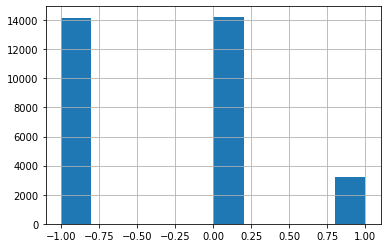

In [157]:
full_data['trend_num'].hist()

### Correlations
#### Logistic Regression on Trend per Feature

See: https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365#:~:text=A%20simple%20approach%20could%20be,variance%20of%20the%20continuous%20variable.&text=If%20the%20variables%20have%20no,similar%20to%20the%20original%20variance.

In [158]:
full_data = full_data.dropna()
full_data = full_data[full_data['trend'] != 'Unknown']

In [159]:
clf = LogisticRegression(random_state=RANDOM_STATE)
runs = []
for col in full_data.columns.values:
    if (full_data[col].dtype == 'int64') | (full_data[col].dtype == 'float64'):
        y = full_data['trend'].copy()
        #y[y.isna()] = 'NULL'
        X = full_data[col]
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33, stratify=y,
                                                    random_state=RANDOM_STATE, shuffle=True)
        X_train = np.array(X_train).reshape(-1,1)
        X_test =  np.array(X_test).reshape(-1,1)
        y_train = np.array(y_train)
        y_test = np.array(y_test)
        clf.fit(X_train, y_train)
        
        y_hat = clf.predict(X_test)
        acc = clf.score(X_test, y_test)
        
        entry = {'column': col, 'acc': acc, 'y': y_test, 'y_hat':y_hat}
        runs.append(entry)
        print('{} predictor accuracy: {}'.format(col, acc))
    # acc_per_col[col] = 

Year predictor accuracy: 0.4506137322593019
perc_area_protected_all_obj predictor accuracy: 0.45464135021097046
perc_area_protected_obj_2 predictor accuracy: 0.45310701956271576
perc_area_protected_obj_3 predictor accuracy: 0.4506137322593019
perc_area_protected_obj_4 predictor accuracy: 0.4487917146144994
perc_area_protected_obj_1a predictor accuracy: 0.4364211737629459
perc_area_protected_obj_1b predictor accuracy: 0.4673954737245877
perc_area_protected_no_obj predictor accuracy: 0.45962792481779824
perc_area_protected_obj_5 predictor accuracy: 0.4614499424626007
perc_area_protected_obj_6 predictor accuracy: 0.47890295358649787
Artificial surfaces predictor accuracy: 0.4579018028385117
Bare area predictor accuracy: 0.4770809359416954
Cropland predictor accuracy: 0.47449175297276563
Grassland predictor accuracy: 0.45310701956271576
Inland water predictor accuracy: 0.43162639048714996
Shrubland predictor accuracy: 0.4798619102416571
Sparse vegetation predictor accuracy: 0.4803413885692

In [160]:
run_df = pd.DataFrame(runs) 
run_df.describe()

acc
count  30.000000
mean    0.477305
std     0.099505
min     0.431626
25%     0.450614
50%     0.457806
75%     0.471399
max     1.000000

#### Pearson Correlation
##### Plot Correlation Matrix

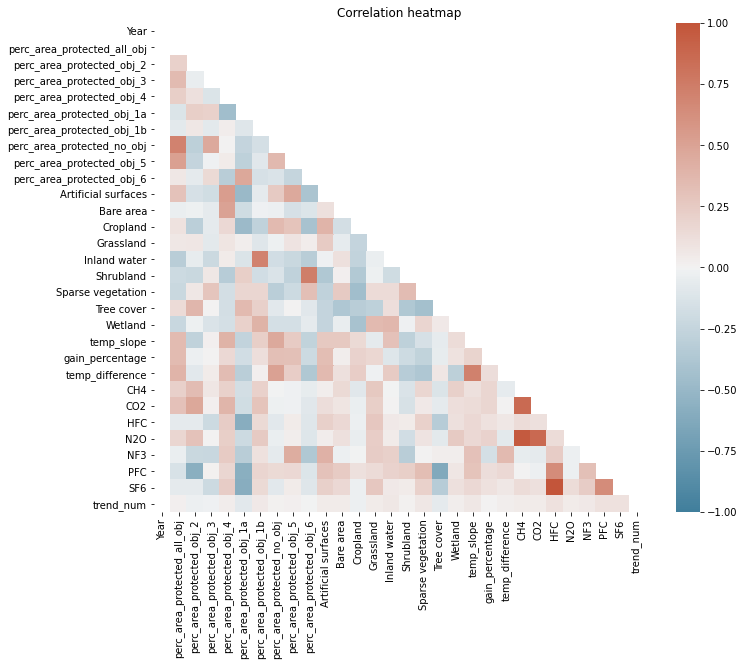

In [161]:
correlation_matrix =  full_data.corr(method= 'pearson')
#visualization of the correlation matrix as heatmap

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask,  cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

#### Conclusion
There appears to be only a slight correlation between the different support features and the trend. 
Pearson correlation seems to show more interpretable results. The attributes with the highest correlation for the logistic regression were 
The transformation of the trend variable before analysing the correlation should be further analysed.
Although there only appears to be a slight correlation, we are going to train models for this task.   

# Models

In [162]:
def extract_from_cv_results(cv_results, row_name=None):
    cv_results = pd.DataFrame(cv_results)
    best_scores = {}
    best_params = {}

    scores = [col.replace('mean_test_', '') for col in cv_results.columns if col.startswith('mean_test_')]
    params = [col for col in cv_results.columns if col.startswith('param_')]

    for score in scores:
        best_params[score] = {}
        # rank is 1 for multiple models if score is equal
        best_model_by_score = cv_results[cv_results[f'rank_test_{score}'] == 1].iloc[0]
        best_scores[f'mean_{score}'] = best_model_by_score[f'mean_test_{score}']
        best_scores[f'std_{score}'] = best_model_by_score[f'std_test_{score}']
        for param in params:
            p = param.split('__')[-1]
            best_params[score][p] = best_model_by_score[param]
    
    best_params = pd.DataFrame(best_params)
    if row_name is None:
        best_scores = pd.DataFrame(best_scores, index=['value'])
    else:
        best_scores = pd.DataFrame(best_scores, index=[row_name])
        best_params['target'] = row_name
        best_params = best_params.reset_index().set_index(['target', 'index'])
    return best_scores, best_params

def results_by_target(data, cv_results_by_target):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    best_scores = []
    best_params = []
    for target in target_columns:
        scores, params = extract_from_cv_results(cv_results_by_target[target], target)
        best_scores.append(scores)
        best_params.append(params)

    best_scores = pd.concat(best_scores)
    best_scores = best_scores.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'std_neg_root_mean_squared_error': 'RMSE_var',
        'mean_neg_mean_absolute_error': 'MAE',
        'std_neg_mean_absolute_error': 'MAE_var'
    })
    best_scores[['RMSE', 'MAE']] = best_scores[['RMSE', 'MAE']].apply(lambda x: -x)
    best_scores[['RMSE_var', 'MAE_var']] = best_scores[['RMSE_var', 'MAE_var']].apply(lambda x: x**2)

    best_params = pd.concat(best_params)
    best_params = best_params.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'mean_neg_mean_absolute_error': 'MAE',
    })

    return best_scores, best_params

def extract_cv_scores(data, cv_results, score):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    results_by_target = {}
    for target in target_columns:
        results = pd.DataFrame(cv_results[target])
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(data.shape[0])]
        cv_scores = [-val for val in cv_scores]
        results_by_target[target] = cv_scores
    return pd.DataFrame(results_by_target)

## Trend
With the data that was merged above, we are now going to train 3 different trend prediction models.
The goal is to predict a trend for a given class of species (kingdom_class) with a given country. 
To do this, we first of all grouped the dataset by kingdom_class and Country. 
The beforehand transformed trend values were averaged. The task was formulated as regression task.
As models we used a Support Vector Machine, a K-NN and a Random Forest.
Each of the models was tested on different parameters, by using a grid search with Leave2GroupsOut Cross Validation. 
The groups that are left out are the respective countries. So for each iteration 2 different countries are held out.
### Group Data by Country and Kingdom. Mean aggregate

<AxesSubplot:>

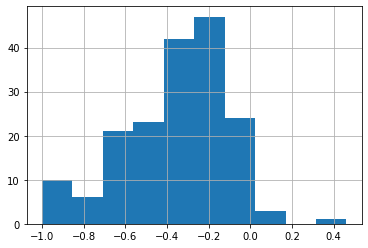

In [173]:
by_country_kingdom = full_data.groupby(['group', 'Country']).mean()
by_country_kingdom = by_country_kingdom.reset_index(drop=False)
by_country_kingdom['trend_num'].hist()


#### Generate Country Labels (Integers) for LeaveGroupOutCV

In [174]:
country_encoder = LabelEncoder()
country_encoder.fit(by_country_kingdom['Country'])
country_labels = country_encoder.transform(by_country_kingdom['Country'])

#### One Hot Encode kingdom_class and Country

In [176]:
by_country_kingdom['group'].unique()


array(['amphibians', 'birds', 'insects', 'mammals', 'reptiles'],
      dtype=object)

In [178]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(by_country_kingdom[['group', 'Country']])
oht_features = enc.transform(by_country_kingdom[['group', 'Country']])
col_names = [
    *by_country_kingdom['group'].unique(),
    *by_country_kingdom['Country'].unique()
]
oht_features = pd.DataFrame(oht_features.todense(), columns=col_names)

In [179]:
y = by_country_kingdom['trend_num']
X = by_country_kingdom.drop(['group', 'Country', 'trend_num'], axis=1)
X = pd.concat([X, oht_features], axis=1)
X.describe()

Year  perc_area_protected_all_obj  perc_area_protected_obj_2  \
count   177.0                   177.000000                 177.000000   
mean   2020.0                     0.219106                   0.041050   
std       0.0                     0.109557                   0.061404   
min    2020.0                     0.056400                   0.000000   
25%    2020.0                     0.139400                   0.006200   
50%    2020.0                     0.192000                   0.020200   
75%    2020.0                     0.279800                   0.048700   
max    2020.0                     0.535300                   0.326100   

       perc_area_protected_obj_3  perc_area_protected_obj_4  \
count                 177.000000                 177.000000   
mean                    0.000584                   0.029312   
std                     0.001171                   0.035269   
min                     0.000000                   0.000100   
25%                     0.000000                   0.003600   
50%                     0.000100                   0.015700   
75%                     0.000500                   0.039600   
max                     0.005900                   0.147400   

       perc_area_protected_obj_1a  perc_area_protected_obj_1b  \
count                  177.000000                  177.000000   
mean                     0.004686                    0.008090   
std                      0.007077                    0.018325   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000700                    0.000000   
75%                      0.005700                    0.003400   
max                      0.021800                    0.075300   

       perc_area_protected_no_obj  perc_area_protected_obj_5  \
count                  177.000000                 177.000000   
mean                     0.073736                   0.041680   
std                      0.089332                   0.058039   
min                      0.000000                   0.000000   
25%                      0.005500                   0.000400   
50%                      0.034700                   0.007800   
75%                      0.114600                   0.072100   
max                      0.403000                   0.252400   

       perc_area_protected_obj_6  ...  Netherlands      Norway      Poland  \
count                 177.000000  ...   177.000000  177.000000  177.000000   
mean                    0.016945  ...     0.028249    0.028249    0.028249   
std                     0.028931  ...     0.166152    0.166152    0.166152   
min                     0.000000  ...     0.000000    0.000000    0.000000   
25%                     0.000000  ...     0.000000    0.000000    0.000000   
50%                     0.000300  ...     0.000000    0.000000    0.000000   
75%                     0.024800  ...     0.000000    0.000000    0.000000   
max                     0.106300  ...     1.000000    1.000000    1.000000   

         Portugal      Russia    Slovenia       Spain      Sweden  \
count  177.000000  177.000000  177.000000  177.000000  177.000000   
mean     0.028249    0.028249    0.028249    0.028249    0.028249   
std      0.166152    0.166152    0.166152    0.166152    0.166152   
min      0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000   

       Switzerland     Iceland  
count   177.000000  177.000000  
mean      0.028249    0.028249  
std       0.166152    0.166152  
min       0.000000    0.000000  
25%       0.000000    0.000000  
50%       0.000000    0.000000  
75%       0.000000    0.000000  
max       1.000000    1.000000 

#### Train Models

In [180]:
# create pipeline for Model
def train_model(X, y, model='svr'):
    if model == 'svr':
        instance = SVR()
        params = {
        'svr__C': [0.1, 0.4, 1, 5, 10], # todo: inform on parameter ranges
        'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
    elif model == 'knn':
        instance = KNeighborsRegressor()
        params = {
            'knn__n_neighbors': [1, 2, 3 , 4 , 5],
            'knn__weights': ['uniform', 'distance']
    }
    elif model == 'rf':
        instance = RandomForestRegressor(max_features = 'sqrt', random_state=RANDOM_STATE)
        params = {
        'rf__n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
    }
    
    
        
    pipeline = Pipeline([
         ('scaling', StandardScaler()), (model, instance)
    ])

    logo = LeavePGroupsOut(n_groups=2)

    grid_search = GridSearchCV(pipeline,
                                    cv=logo,
                                   
                                    param_grid=params,
                                    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                                    refit='neg_root_mean_squared_error', verbose=2, n_jobs=-1)
    
    grid_search.fit(X, y, groups=country_labels)

    return pd.DataFrame(grid_search.cv_results_)


##### Support Vector Machine

In [181]:
svr_results = train_model(X, y, model='svr')

Fitting 630 folds for each of 20 candidates, totalling 12600 fits


##### K-NN

In [182]:
knn_results = train_model(X, y, model='knn')

Fitting 630 folds for each of 10 candidates, totalling 6300 fits


##### Random Forest

In [183]:
rf_results = train_model(X, y, model='rf')

Fitting 630 folds for each of 10 candidates, totalling 6300 fits


KeyboardInterrupt: 

##### Support Vector Machine

In [ ]:
svr_best_scores, svr_best_params = extract_from_cv_results(svr_results)
display(svr_best_scores)
display(svr_best_params)

##### K-NN

In [ ]:
knn_best_scores, knn_best_params = extract_from_cv_results(knn_results)
display(knn_best_scores)
display(knn_best_params)

##### Random Forest

In [ ]:
rf_best_scores, rf_best_params = extract_from_cv_results(rf_results)
display(rf_best_scores)
display(rf_best_params)

#### Comparision of classifiers

In [ ]:
def boxplot_results(cv_result_list):
    score = 'neg_root_mean_squared_error'
    fig, axs = plt.subplots(3, figsize=(10, 5))
    fig.suptitle('RMSE Scores Leave2GroupsOut CV (group=Country)')
    max_x = 0
    for i, cv_res in enumerate(cv_result_list):
        results = cv_res
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(by_country_kingdom['Country'].nunique())]
        cv_scores = [-val for val in cv_scores]
        temp_max = np.max(cv_scores)
        if temp_max > max_x:
            max_x = temp_max
        sns.boxplot(data=cv_scores, orient='h', ax=axs[i])
    axs[0].set_title('Support Vector Machine')
    axs[1].set_title('K-NN')
    axs[2].set_title('Random Forest')
    
    axs[0].set_xlim([0.05,max_x + 0.05])
    axs[1].set_xlim([0.05,max_x + 0.05])
    axs[2].set_xlim([0.05,max_x + 0.05])
    
    plt.tight_layout()
    plt.show()

In [ ]:
boxplot_results([svr_results, knn_results, rf_results])

#### Conclusion

The k-NN model seems to work best for the trend prediction. In the best parameter configuration
the k-NN reaches a mean RMSE of 0.24 and a MAE of 0.17. The best configuration ranked by RMSE has 3 neighbors and distance weights.

Altough the RMSE of the classifiers seems quite low, the predictions are not really accurate, because the target ranges only between -1.0 and 0.4 (after the grouping). 

The reason for this is possibly the data quality (missing time information, different datasets from different years,
no historical data, ...) and the low correlation between features and target. 

## Relative Threatened Species
### Check correlation of our features and target values for the relative threatened species by country and group 
For our correlation analysis, we exclude our non continuous variables (the binary value whether a taxonomic group has records for that specific country)

In [ ]:
full_threatened_corr = full_threatened.copy()
full_threatened_corr = full_threatened.drop(columns=['mammals_resident', 'insects_resident', "amphibians_resident", "birds_resident", "reptiles_resident", "Year"])

In [ ]:
#full correlation matrix to also get an overview of correlations between different features
full_threatened_corr.corr(method= 'pearson')

In [ ]:
#visualization of the correlation matrix as heatmap
correlation_matrix = full_threatened_corr.corr(method='pearson')
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Correlation heatmap')

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# create heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0)
plt.show()

To get a better overview of our targets we calculate the correlation of the features with each target separately

In [ ]:
#pearsons rho for the correlation of the values for all groups with our features
for col in full_threatened_corr:
    target = 'total_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened mammals with our features
for col in full_threatened_corr:
    target = 'mammals_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened insects with our features
for col in full_threatened_corr:
    target = 'insects_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened amphibians with our features
for col in full_threatened_corr:
    target = 'amphibians_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened birds with our features
for col in full_threatened_corr:
    target = 'birds_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

In [ ]:
#pearsons rho for the correlation of the threatened reptiles with our features
for col in full_threatened_corr:
    target = 'reptiles_threatened'
    exclude =  ['Country','total_threatened', 'mammals_threatened', 'insects_threatened', 'amphibians_threatened','birds_threatened', 'reptiles_threatened']
    correlations = {}
    if col not in exclude:
        correlations[col + ' pearsons correlation with ' + target] = round(full_threatened_corr[col].corr(full_threatened_corr[target]),5)
        print(correlations)

### Conclusion
We can see many major difference between the groups regarding the correlation to each feature. One thing that can be seen is that sparse vegetation correlates stronger with the number of threatened mammals than with any other group. Overall we can see the highest positive correlation for the amount of shrubland of a country and the highest negative correlation for nitrous oxide. As we divided the features into four groups (protected areas, land cover, temperature and greenhouse gases), we can see that for every group we have at least some variables that contributed to the prediction of our targets, so we decide to keep those four groups for our model building process and start with the full model.

## Relative Number of Threatened Species
### Modeling the data

The target values that we are intersted in are the relative number of threatened species per group and the relative numbers of the trend.
For this we create a model for each target value und capture the RMSE and MAE for each model. As the goal is to see the predicitve power of the models we do not perform exhaustive hyperparameter optimization but only run a Grid Search by model and use the model with the best observed RMSE. The best params per target are reported.

For the evaluation we use Leave on Out CV for the model because we are limited in the number of observations (countries)

In [ ]:
data = pd.concat([
        ds_climate.set_index('Country'), 
        ds_ghg.set_index('Country'), 
        ds_land_cover.set_index('Country'),
        ds_protected_areas.set_index('Country'), 
        ds_threatened_by_group.set_index('Country'), 
        ds_trend_by_group], 
        join='inner', 
        axis=1)
data.shape


In [ ]:
data.columns

In [ ]:
data.describe()

In [ ]:
# are there any missing numbers
data.isna().any().sum()

### kNN

In [ ]:
def knn_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('knn', KNeighborsRegressor())
        ])

        # define grid search parameters
        params = {
            'knn__n_neighbors': [1, 2, 3 , 4 , 5],
            'knn__weights': ['uniform', 'distance']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

knn_cv_results = knn_by_target(data)

In [ ]:
knn_best_scores, knn_best_params = results_by_target(data, knn_cv_results)
knn_best_scores

In [ ]:
knn_best_params

In [ ]:
# get data
vis_knn_scores = extract_cv_scores(data, knn_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('KKN Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

### Support Vector Regression

We select support vector regression mainly because they are:
- Effective in high dimensional spaces.
- Still effective in cases where number of dimensions is greater than the number of samples.

In [ ]:
def svr_by_target(data):
    cv_results = {}

    # iterate all tartget veriables
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in target_columns:
        y = data[target]
        X = data.drop(columns=target_columns)

        # create pipeline for Model
        svr = Pipeline([
            ('scaling', StandardScaler()),
            ('svr', SVR())
        ])

        # define grid search parameters
        params = {
            'svr__C': [0.1, 0.3, 0.5, 0.8, 1, 2, 5],
            'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
        }

        svm_grid_search = GridSearchCV(
            svr,
            cv=LeaveOneOut(),
            param_grid=params,
            scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
    
        svm_grid_search.fit(X, y)

        cv_results[target] = svm_grid_search.cv_results_

    return cv_results

svr_cv_results = svr_by_target(data)

In [ ]:
svr_best_scores, svr_best_params = results_by_target(data, svr_cv_results)
svr_best_scores

In [ ]:
svr_best_params

In [ ]:
# get data
vis_knn_scores = extract_cv_scores(data, svr_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Support Vector Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_knn_scores, orient='h')
plt.show()

### Random Forest Regression
We perform random forest regression here to predict the outcome of our relative threatened species for all groups combined and for each group separately, as well as the trends. As a random forest is a tree partitioning algorithm it does by nature not need any scaling of the data beforehand. After the results of our correlation analysis we start with the full model here.
As the number of samples in our remaining data frame is quite limited, we use leave one out cross validation to measure the performance of our regressor rather than a train/test split.Because of the high dimension of the data, we take the square root of the total number of features to pick for every split. We also try different values for the number of decision trees created.

In [ ]:
complete_data = pd.concat([
        ds_climate.set_index('Country'), 
        ds_ghg.set_index('Country'), 
        ds_land_cover.set_index('Country'),
        ds_protected_areas.set_index('Country'), 
        ds_threatened_by_group.set_index('Country'), 
        ds_trend_by_group], 
        join='inner', 
        axis=1)

In [ ]:
rf_data = complete_data.copy()
rf_data.shape

In [ ]:
def rf_predict_threatened_relative(data):
    cv_results = {}

    # iterate all target variables
    columns_threatened = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in columns_threatened:
        y = data[target]
        X = data.drop(columns=columns_threatened)

        # n_estimator(number of trees) is the hyperparameter that we try to optimize here
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        grid = random_grid = {'n_estimators': n_estimators}
        rf=RandomForestRegressor(max_features = 'sqrt', random_state=0)
        rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = LeaveOneOut(),  scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
        rf_grid.fit(X,y)    
        cv_results[target] = rf_grid.cv_results_

    return cv_results
rf_cv_results = rf_predict_threatened_relative(complete_data)

In [ ]:
rf_best_scores, rf_best_params = results_by_target(complete_data, rf_cv_results)
rf_best_scores

In [ ]:
rf_data

In [ ]:
# get data
vis_rf_scores = extract_cv_scores(complete_data, rf_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Random Forest Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_rf_scores, orient='h')
plt.show()

### Value Ranges
As performance metric we used the RMSE and the MAE here. To get an understanding of what these values mean and how they can be interpreted, we take a look at our data again and look at the value ranges to then interpret the results.

In [ ]:
target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
complete_data[target_columns].describe()

TO DO: UPDATE
As the range of our threatened species percentage of all groups is from 1.7%-16.7%, a RMSE of 5% is a pretty big offset. For amphibians the RMSE even suggests a mean 16% offset (maximum for all targets). These values indicate rather bad predictions that suggest that our model is not very well suited to predict the percentage of threatened animals in a country.

### Compare Models

In [ ]:
# prepare data for visualization
vis_knn = knn_best_scores.reset_index().rename(columns={'index': 'target'})
vis_knn['model_type'] = 'KNN'
vis_svr = svr_best_scores.reset_index().rename(columns={'index': 'target'})
vis_svr['model_type'] = 'SVR'
vis_rf = rf_best_scores.reset_index().rename(columns={'index': 'target'})
vis_rf['model_type'] = 'RF'
df =pd.concat([vis_knn, vis_svr, vis_rf])

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('RMSE by Model and Target')

# create heatmap
sns.lineplot(data=df, x='target', y='RMSE', hue='model_type')
plt.xticks(rotation=45, ha='right')
plt.show()